# Score-Based Generative Modeling: Application for Sea Surface Turbidity Reconstruction
This tutorial is a 3D input setting (2D dimension+1D for the time series) using Unet3D (with conv3D), Song's original tutorial for 2D setting can be found [here](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=21v75FhSkfCq) (but note that this Song's code is for MNIST dataset, 2D setting and unconditional generative setting). Song's paper: Yang Song, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, and Ben Poole. "[Score-Based Generative Modeling through Stochastic Differential Equations.](https://arxiv.org/pdf/2011.13456.pdf)" Internation Conference on Learning Representations, 2021

Before running this code, you can download the dataset (which is sea surface turbidity of the Dutch Wadden Sea, OSE from CMEMS) used in this tutorial [here](https://drive.google.com/drive/folders/1NpwSLr8HEOYcGbQWXY6gC__GcxO12Abt?usp=sharing) . We use satellite observation as gappy ground truth because we do not have access to gap-free ground truth. The input actually this gappy ground truth, which is further augmented with artificially added rectangular patches as you can see below figure. In that figure, you can see three different samples in the middle; these samples are generated using the mask (shown on the left as input), and we strive to make these samples closely resemble the gappy ground truth (shown on the right) by minimizing the loss function.


![ncsnv2](https://github.com/nguyenthuynga/Diffusion/blob/main/Images/diffusion_generative.png?raw=true)


Compared to Song's orginal tutorial, I made quite many changes. All the changes are marked by #change with a number, below are the main ones:
- This is a conditional setting for tasks such as interpolation/mapping/reconstruction, where the score-based model UNet is designed to take two types of input: Gaussian noise and a mask as the condition (along with time step). The figure above demonstrates this: the mask (on the left) is used as the input to the score model. Our goal is to learn the distribution of the dataset effectively so that the model can generate outputs that closely resemble the ground truth (shown on the far right). The three images in the middle display samples generated by our conditional score model, illustrating how it generate different samples (from different Gaussian noise as input) under the mask as condition.
- Customize the DataLoader to take our data as input (instead of MNIST). To avoid exploding gradient, we reduce the percentage of batches which has too less available data, apply gradient clipping within the PyTorch framework. Because we need a big dataset in as mentioned above, but my dataset is small (2K images) with the original size of 200*300, to increase the amount of data so train on a random small area of size 112*112, by doing that I can crop different areas as a way to augment the number of images.
- Customize the loss function to process only non-NaN areas. 
- Training requires long time + big dataset. Since in this score-based model training setting, each epoch of training involves learning one step of denoising, while the whole denoising process encompasses around 500 steps. So, in each step, we learn a small thing. That is why: 1, we need many epochs learning. 2,  big dataset, because otherwise the training process is getting overfit before it actually learns something useful.
- We customized for 3D setting in the Unet architecture, in both training and sampling phase.
- Many other small changes that is noted in the code starting with “#change “...

If something in the code isn't clear for you, don't hesitate to contact me at nga.nguyen@imt-atlantique.fr

![ncsnv2](https://github.com/nguyenthuynga/Diffusion/blob/main/Images/random_crop_small_area.png?raw=true)

Diffusion models require very large datasets; however, our dataset is relatively small. To mitigate overfitting, we implement augmentation by cropping and training only on smaller areas. This technique allows us to generate multiple random smaller images from each original image, effectively enriching our dataset by 5-10 times. The original images are 200x300 pixels, while the cropped areas are 112x112 pixels, as you can see we define below size_0 and size_1.

In [3]:
# Choosing the GPU
import os
gpu = "0"  # The GPU number to use.
os.environ["CUDA_VISIBLE_DEVICES"] = gpu  # Ensure this line is in every cell that requires GPU usage.



In [4]:
# Declare the size of the (cropped) input image for 3D settings 1*time_window*size_0*size_1 (1 here standing for the channel, which is defaut one)
size_0 = 112  # Spatial dimension for latitude
size_1 = 112  # Spatial dimension for longtitude
time_window = 16  # Temporal dimension, added to accommodate the 3D input.


In [5]:
#Loading the datasets
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
import xarray as xr 
import numpy as np

# Paths to the datasets
path_GT="/Odyssey/private/n23nguye/data_nga/Delft3Dmodel_CMEMS_size200T300/CMEMS/GT_CMEMS_size200T300_log10.nc" #path to the gappy ground truth, since we do not have gap free ground truth, we use gappy satellite observation as ground truth. 
# path_land="/DATASET/data_nga/Delft3Dmodel_CMEMS_size200T300/CMEMS/land_mask_CMEMS_size200T300.nc" #path to the land mask, this is optional
path_GT_with_artificialgappy="/Odyssey/private/n23nguye/data_nga/Delft3Dmodel_CMEMS_size200T300/CMEMS/Obs_patch_CMEMS_size200T300_log10_0.5RemovedCloud_correctVersion.nc"#path to the gappy input, where we add some artificial square to remove the data. 

# Optionally, restrict the data loaded to a small time slice for initial checks
time_slice = None  # e.g., slice(0, 20) to load only the first 20 time steps

if time_slice is not None:
    GT=xr.open_dataset(path_GT).isel(time=time_slice)
    GT_with_artificialgappy=xr.open_dataset(path_GT_with_artificialgappy).isel(time=time_slice)
else:
    GT=xr.open_dataset(path_GT)
    GT_with_artificialgappy=xr.open_dataset(path_GT_with_artificialgappy)

# Display basic information about the loaded ground truth
print("GT: ", GT)

# Explore the subset of data: by defining slices for spatial cropping based on desired size
lat_slice=slice(0, 0+size_0)
lon_slice=slice(60, 60+size_1)
GT_subset = GT.isel(lat=lat_slice, lon=lon_slice)
GT_with_artificialgappy_subset = GT_with_artificialgappy.isel(lat=lat_slice, lon=lon_slice)

# Print the subset dataset information
print("GT_subset: ",GT_subset)
print("GT_with_artificialgappy_subset: ",GT_with_artificialgappy_subset)

GT:  <xarray.Dataset> Size: 526MB
Dimensions:  (time: 2192, lat: 200, lon: 300)
Coordinates:
  * lat      (lat) float32 800B 52.55 52.56 52.57 52.58 ... 54.6 54.61 54.62
  * lon      (lon) float32 1kB 4.234 4.245 4.255 4.266 ... 7.328 7.339 7.349
  * time     (time) datetime64[ns] 18kB 2015-01-01 2015-01-02 ... 2020-12-31
Data variables:
    SPM      (time, lat, lon) float32 526MB ...
Attributes:
    Conventions:       CF-1.11
    title:             cmems_obs-oc_atl_bgc-transp_my_l3-multi-1km_P1D
    institution:       ACRI
    source:            surface observation
    history:           Created using software developed at ACRI-ST
    contact:           servicedesk.cmems@acri-st.fr
    references:        http://www.globcolour.info GlobColour has been origina...
    comment:           average
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  OCEANCOLOUR_ATL_BGC_L3_MY_009_113
    subset:datasetId:  cmems_obs-oc_atl_bgc-transp_my_l3-m

In [6]:
#separate train and validation set, the year 2020 is used for validation, the remainning is used for training set
GT_train = GT.sel(time=slice('2015-01-01', '2019-12-31'))
GT_val = GT.sel(time='2020')

print('GT_val', GT_val)

GT_with_artificialgappy_train = GT_with_artificialgappy.sel(time=slice('2015-01-01', '2019-12-31'))
GT_with_artificialgappy_val = GT_with_artificialgappy.sel(time='2020')


GT_val <xarray.Dataset> Size: 88MB
Dimensions:  (time: 366, lat: 200, lon: 300)
Coordinates:
  * lat      (lat) float32 800B 52.55 52.56 52.57 52.58 ... 54.6 54.61 54.62
  * lon      (lon) float32 1kB 4.234 4.245 4.255 4.266 ... 7.328 7.339 7.349
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    SPM      (time, lat, lon) float32 88MB ...
Attributes:
    Conventions:       CF-1.11
    title:             cmems_obs-oc_atl_bgc-transp_my_l3-multi-1km_P1D
    institution:       ACRI
    source:            surface observation
    history:           Created using software developed at ACRI-ST
    contact:           servicedesk.cmems@acri-st.fr
    references:        http://www.globcolour.info GlobColour has been origina...
    comment:           average
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  OCEANCOLOUR_ATL_BGC_L3_MY_009_113
    subset:datasetId:  cmems_obs-oc_atl_bgc-transp_my_l3-mul

GT_subset_time1:  <xarray.Dataset> Size: 51kB
Dimensions:  (lat: 112, lon: 112)
Coordinates:
  * lat      (lat) float32 448B 52.55 52.56 52.57 52.58 ... 53.68 53.69 53.7
  * lon      (lon) float32 448B 4.859 4.87 4.88 4.891 ... 5.995 6.005 6.016
    time     datetime64[ns] 8B 2015-06-30
Data variables:
    SPM      (lat, lon) float32 50kB ...
Attributes:
    Conventions:       CF-1.11
    title:             cmems_obs-oc_atl_bgc-transp_my_l3-multi-1km_P1D
    institution:       ACRI
    source:            surface observation
    history:           Created using software developed at ACRI-ST
    contact:           servicedesk.cmems@acri-st.fr
    references:        http://www.globcolour.info GlobColour has been origina...
    comment:           average
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  OCEANCOLOUR_ATL_BGC_L3_MY_009_113
    subset:datasetId:  cmems_obs-oc_atl_bgc-transp_my_l3-multi-1km_P1D_202311
    subset:date:       

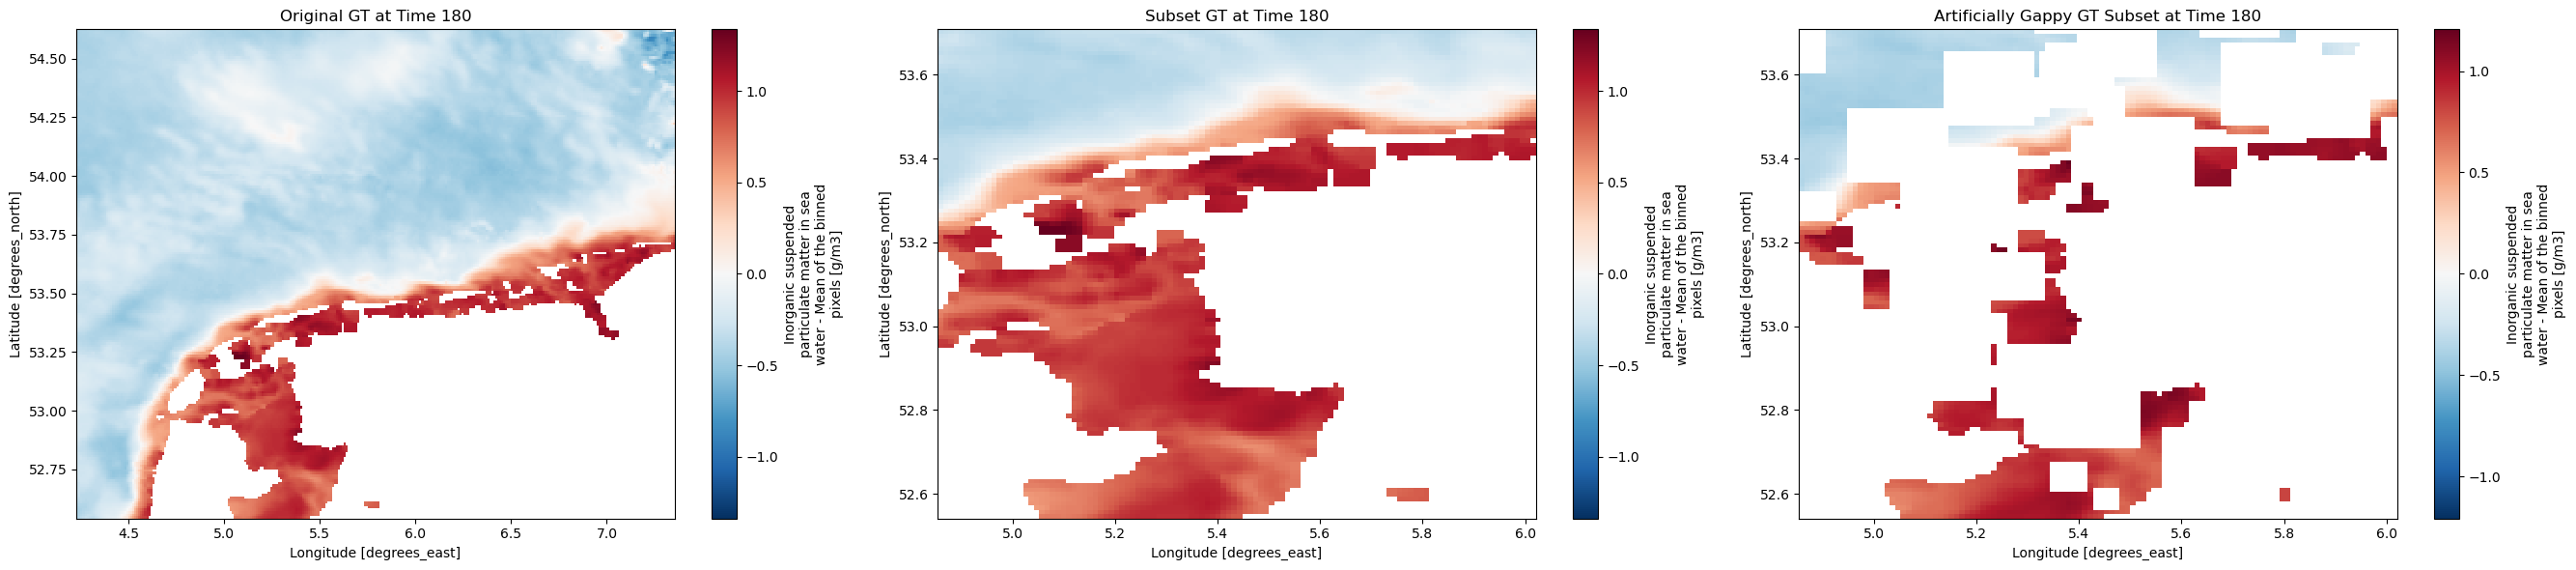

In [7]:
#plot GT and GT_subset to visualize the data for one specific day: note that in training process, the input is of size 112*112 as GT_subset, and not 200*300 as GT
import matplotlib.pyplot as plt
# Select the data for a specific time index
time = 180

# Load data for the specified time
GT_time1 = GT.isel(time=time)
GT_subset_time1 = GT_subset.isel(time=time)
GT_with_artificialgappy_time1 = GT_with_artificialgappy.isel(time=time)
GT_with_artificialgappy_subset_time1 = GT_with_artificialgappy_subset.isel(time=time)

print("GT_subset_time1: ", GT_subset_time1)
print("GT_with_artificialgappy_subset_time1: ", GT_with_artificialgappy_subset_time1)

# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(27, 6))

# Plot the original data at specified time
GT_time1.SPM.plot(ax=axes[0])
axes[0].set_title(f'Original GT at Time {time}')

# Plot the subset of the original data at specified time
GT_subset_time1.SPM.plot(ax=axes[1])
axes[1].set_title(f'Subset GT at Time {time}')

# Plot the subset of artificially gappy data at specified time
GT_with_artificialgappy_subset_time1.SPM.plot(ax=axes[2])
axes[2].set_title(f'Artificially Gappy GT Subset at Time {time}')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Note that, the dataloader below will process 3D input (instead of 2D input)

In [8]:
"""Technical remark: In below dataloader, you can see I used "if valid_loss_mask.sum() <threshold:" in  #change 54c: to avoid NaN loss due to large amount of NaN,
because otherwise the gradient is exploding more frequent (if too much NaN values present in the input). We can remove this if condition as well, 
since anyway in the training process later on, I also exclude the batches wiht exploding gradient from the accumulating the final loss"""

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class XArrayDatasetWithMask(Dataset):
    def __init__(self, GT, GT_mask, crop_size, output_size, time_window=None, transform=None):
        """
        Dataset to handle ground truth and mask data.
        Args:
        GT (xarray.Dataset): Dataset containing the ground truth.
        GT_mask (xarray.Dataset): Dataset containing the masks.
        crop_size (tuple): Tuos.environ["CUDA_VISIBLE_DEVICES"] = gpuple indicating the size of the crops.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.GT_data = GT['SPM'].values  # Assuming 'SPM' is the variable in the dataset
        self.mask_data = GT_mask['SPM'].values  # Assuming mask data is stored similarly
        self.crop_size = crop_size
        self.output_size = output_size
        self.transform = transform
        self.time_window = time_window
        self.random_crop = transforms.RandomCrop(crop_size)  # Random crop transformation

    def __len__(self):
        return self.GT_data.shape[0] - self.time_window + 1  
    
    def __getitem__(self, idx): 
        gt_sample = self.GT_data[idx:idx+self.time_window]  
        mask_sample = self.mask_data[idx:idx+self.time_window]
        
        gt_sample = torch.tensor(gt_sample, dtype=torch.float32).unsqueeze(1)#the size will be (time_window, 1, size_0, size_1 here)
        mask_sample = torch.tensor(mask_sample, dtype=torch.float32).unsqueeze(1)
        
        # Apply the same random crop to all time steps
        i, j, h, w = self.random_crop.get_params(gt_sample[0], self.random_crop.size)  # Use the first time step to get crop params
        # print("gt_sample.shape before crop: ", gt_sample.shape)
        gt_sample=transforms.functional.crop(gt_sample, i, j, h, w).squeeze(1).unsqueeze(0) # so that the dimension will be (time_window,1, size_0,size_1)
        mask_sample=transforms.functional.crop(mask_sample, i, j, h, w).squeeze(1).unsqueeze(0) # so that the dimension will be (time_window,1, size_0,size_1)
        # print("gt_sample.shape after crop: ",transforms.functional.crop(gt_sample, i, j, h, w).shape)
        
        ### return the sample only when there is valid values in mask_sample y
        mask_x_not_nan = ~torch.isnan(gt_sample)  # True where x is not NaN
        valid_loss_mask = mask_x_not_nan

        threshold = np.prod(gt_sample.shape) * 0.1 #to avoid NaN loss due to large amount of NaN,  the quality and completeness of the input data directly impact the computation of loss.
        if valid_loss_mask.sum() <threshold: # to avoid NaN loss due to large amount of NaN
            # If all values are NaN, retry with a new random index
            # This assumes the dataset is large enough to find a valid sample after a few tries
            return self.__getitem__((idx + 1) % len(self))  # Ensure index stays within bounds
        else:
            # Return the pair of image and mask if the mask has non-NaN values
            return gt_sample, mask_sample


crop_size = (size_0, size_1)  # Define your crop size
output_size=(size_0, size_1)#change 20: I change output size here


#change 48b: separate train and val here
#change 49e: add time window here
train_dataset = XArrayDatasetWithMask(GT_train, GT_with_artificialgappy_train, crop_size=crop_size, output_size=output_size, time_window=time_window)
val_dataset = XArrayDatasetWithMask(GT_val, GT_with_artificialgappy_val, crop_size=crop_size, output_size=output_size, time_window=time_window)


train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Testing the shape in DataLoader
for gt_sample, mask_sample in train_data_loader:
    print("Shape GT :", gt_sample.shape)
    print("Shape mask :", mask_sample.shape)
    break

/Odyssey/private/n23nguye/envs/nga/miniconda/envs/diffusion/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shape GT : torch.Size([32, 1, 16, 112, 112])
Shape mask : torch.Size([32, 1, 16, 112, 112])


Shape GT: torch.Size([32, 1, 16, 112, 112])
Shape mask: torch.Size([32, 1, 16, 112, 112])


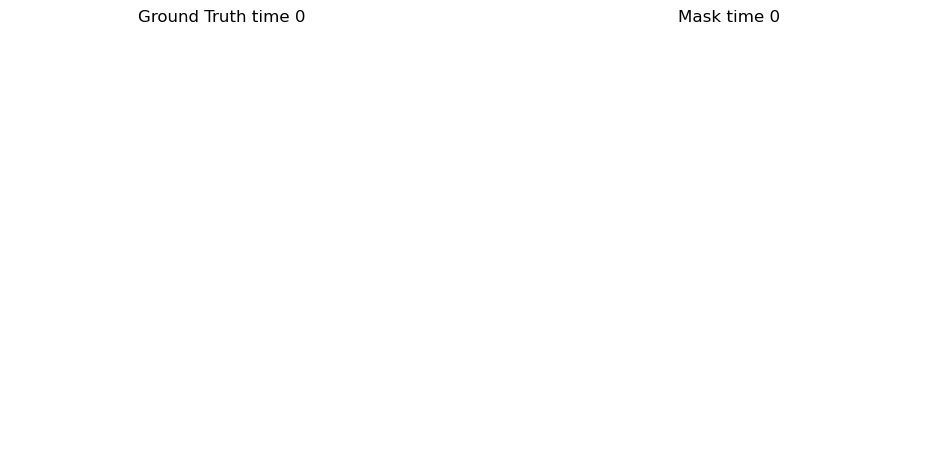

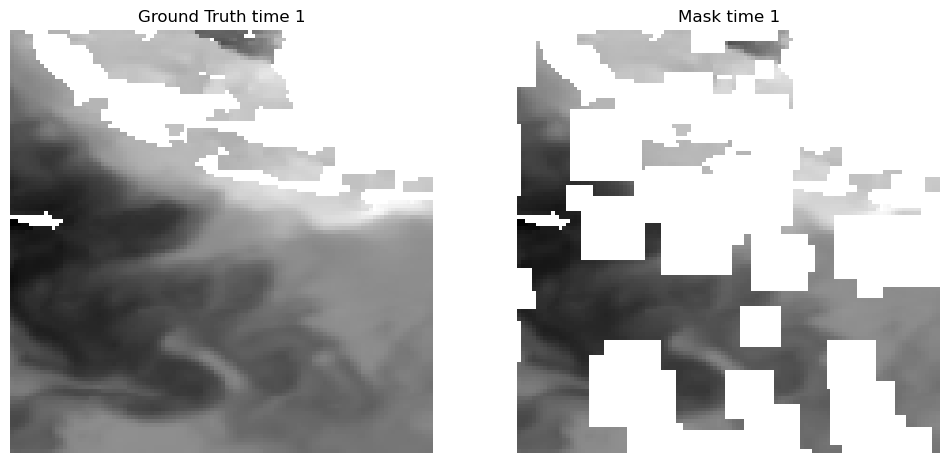

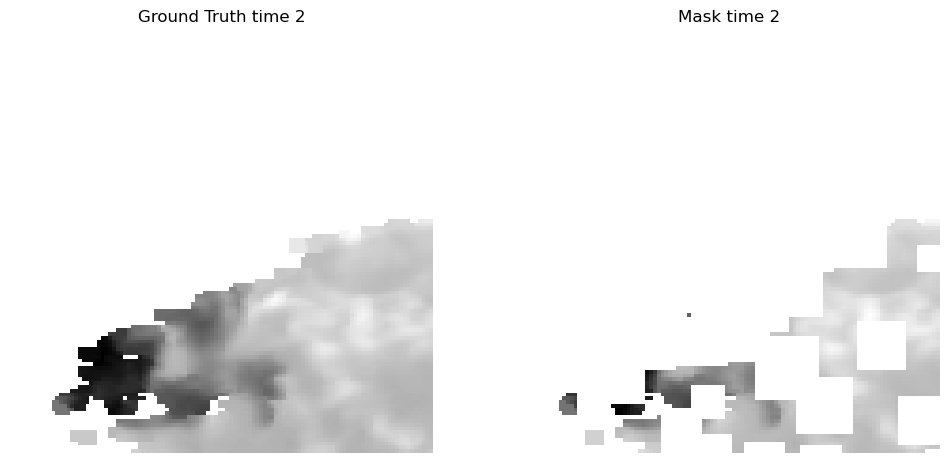

In [9]:
# (Optional) Exploring some features of the dataset

import matplotlib.pyplot as plt

for gt_sample, mask_sample in train_data_loader:
    print("Shape GT:", gt_sample.shape)
    print("Shape mask:", mask_sample.shape)

    sample_number=10
    # Plot the first sample in the batch
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(gt_sample[sample_number][0,0], cmap='gray')#change 49f and change 50: plot only the 1st time window of the input
    ax[0].set_title('Ground Truth time 0')
    ax[0].axis('off')  # Hide the axes ticks
    # Show the mask sample
    ax[1].imshow(mask_sample[sample_number][0,0], cmap='gray')
    ax[1].set_title('Mask time 0')
    ax[1].axis('off')  # Hide the axes ticks
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(gt_sample[sample_number][0,1], cmap='gray')#change 49f and change 50: plot only the 1st time window of the input
    ax[0].set_title('Ground Truth time 1')
    ax[0].axis('off')  # Hide the axes ticks
    # Show the mask sample
    ax[1].imshow(mask_sample[sample_number][0,1], cmap='gray')
    ax[1].set_title('Mask time 1')
    ax[1].axis('off')  # Hide the axes ticks
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(gt_sample[sample_number][0,2], cmap='gray')#change 49f and change 50: plot only the 1st time window of the input
    ax[0].set_title('Ground Truth time 2')
    ax[0].axis('off')  # Hide the axes ticks
    # Show the mask sample
    ax[1].imshow(mask_sample[sample_number][0,2], cmap='gray')
    ax[1].set_title('Mask time 2')
    ax[1].axis('off')  # Hide the axes ticks
    plt.show()

    break  # Only process the first batch

## Introduction about the score-based model approach

### Score and Score-Based Models
Given a probablity density function $p(\mathbf{x})$, we define the *score* as $$\nabla_\mathbf{x} \log p(\mathbf{x}).$$ As you might guess, score-based generative models are trained to estimate $\nabla_\mathbf{x} \log p(\mathbf{x})$. Unlike likelihood-based models such as flow models or autoregressive models, score-based models do not have to be normalized and are easier to parameterize. For example, consider a non-normalized statistical model $p_\theta(\mathbf{x}) = \frac{e^{-E_\theta(\mathbf{x})}}{Z_\theta}$, where $E_\theta(\mathbf{x}) \in \mathbb{R}$ is called the energy function and $Z_\theta$ is an unknown normalizing constant that makes $p_\theta(\mathbf{x})$ a proper probability density function. The energy function is typically parameterized by a flexible neural network. When training it as a likelihood model, we need to know the normalizing constant $Z_\theta$ by computing complex high-dimensional integrals, which is typically intractable. In constrast, when computing its score, we obtain $\nabla_\mathbf{x} \log p_\theta(\mathbf{x}) = -\nabla_\mathbf{x} E_\theta(\mathbf{x})$ which does not require computing the normalizing constant $Z_\theta$.

In fact, any neural network that maps an input vector $\mathbf{x} \in \mathbb{R}^d$ to an output vector $\mathbf{y} \in \mathbb{R}^d$ can be used as a score-based model, as long as the output and input have the same dimensionality. This yields huge flexibility in choosing model architectures.

### Perturbing Data with a Diffusion Process

In order to generate samples with score-based models, we need to consider a [diffusion process](https://en.wikipedia.org/wiki/Diffusion_process) that corrupts data slowly into random noise. Scores will arise when we reverse this diffusion process for sample generation. You will see this later in the notebook.

A diffusion process is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process#:~:text=A%20stochastic%20or%20random%20process%20can%20be%20defined%20as%20a,an%20element%20in%20the%20set.) similar to [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). Their paths are like the trajectory of a particle submerged in a flowing fluid, which moves randomly due to unpredictable collisions with other particles. Let $\{\mathbf{x}(t) \in \mathbb{R}^d \}_{t=0}^T$ be a diffusion process, indexed by the continuous time variable $t\in [0,T]$. A diffusion process is governed by a stochastic differential equation (SDE), in the following form

\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}

where $\mathbf{f}(\cdot, t): \mathbb{R}^d \to \mathbb{R}^d$ is called the *drift coefficient* of the SDE, $g(t) \in \mathbb{R}$ is called the *diffusion coefficient*, and $\mathbf{w}$ represents the standard Brownian motion. You can understand an SDE as a stochastic generalization to ordinary differential equations (ODEs). Particles moving according to an SDE not only follows the deterministic drift $\mathbf{f}(\mathbf{x}, t)$, but are also affected by the random noise coming from $g(t) d\mathbf{w}$. From now on, we use $p_t(\mathbf{x})$ to denote the distribution of $\mathbf{x}(t)$. 

For score-based generative modeling, we will choose a diffusion process such that $\mathbf{x}(0) \sim p_0$, and $\mathbf{x}(T) \sim p_T$. Here $p_0$ is the data distribution where we have a dataset of i.i.d. samples, and $p_T$ is the prior distribution that has a tractable form and easy to sample from. The noise perturbation by the diffusion process is large enough to ensure $p_T$ does not depend on $p_0$.

### Reversing the Diffusion Process Yields Score-Based Generative Models
By starting from a sample from the prior distribution $p_T$ and reversing the diffusion process, we will be able to obtain a sample from the data distribution $p_0$. Crucially, the reverse process is a diffusion process running backwards in time. It is given by the following reverse-time SDE

\begin{align}
  d\mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g^2(t)\nabla_{\mathbf{x}}\log p_t(\mathbf{x})] dt + g(t) d\bar{\mathbf{w}},
\end{align}

where $\bar{\mathbf{w}}$ is a Brownian motion in the reverse time direction, and $dt$ represents an infinitesimal negative time step. This reverse SDE can be computed once we know the drift and diffusion coefficients of the forward SDE, as well as the score of $p_t(\mathbf{x})$ for each $t\in[0, T]$.

The overall intuition of score-based generative modeling with SDEs can be summarized in the illustration below

![ncsnv2](https://github.com/nguyenthuynga/Diffusion/blob/main/Images/diffusion_scorebased.png?raw=true)


### Score Estimation

Based on the above intuition, we can use the time-dependent score function $\nabla_\mathbf{x} \log p_t(\mathbf{x})$ to construct the reverse-time SDE, and then solve it numerically to obtain samples from $p_0$ using samples from a prior distribution $p_T$. We can train a time-dependent score-based model $s_\theta(\mathbf{x}, t)$ to approximate $\nabla_\mathbf{x} \log p_t(\mathbf{x})$, using the following weighted sum of [denoising score matching](http://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf) objectives.

\begin{align}
\min_\theta \mathbb{E}_{t\sim \mathcal{U}(0, T)} [\lambda(t) \mathbb{E}_{\mathbf{x}(0) \sim p_0(\mathbf{x})}\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2]],
\end{align}
where $\mathcal{U}(0,T)$ is a uniform distribution over $[0, T]$, $p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$ denotes the transition probability from $\mathbf{x}(0)$ to $\mathbf{x}(t)$, and $\lambda(t) \in \mathbb{R}_{>0}$ denotes a positive weighting function.

In the objective, the expectation over $\mathbf{x}(0)$ can be estimated with empirical means over data samples from $p_0$. The expectation over $\mathbf{x}(t)$ can be estimated by sampling from $p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$, which is efficient when the drift coefficient $\mathbf{f}(\mathbf{x}, t)$ is affine. The weight function $\lambda(t)$ is typically chosen to be inverse proportional to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]$.



### Time-Dependent Score-Based Model

There are no restrictions on the network architecture of time-dependent score-based models, except that their output should have the same dimensionality as the input, and they should be conditioned on time.

Several useful tips on architecture choice:
* It usually performs well to use the [U-net](https://arxiv.org/abs/1505.04597) architecture as the backbone of the score network $s_\theta(\mathbf{x}, t)$,

* We can incorporate the time information via [Gaussian random features](https://arxiv.org/abs/2006.10739). Specifically, we first sample $\omega \sim \mathcal{N}(\mathbf{0}, s^2\mathbf{I})$ which is subsequently fixed for the model (i.e., not learnable). For a time step $t$, the corresponding Gaussian random feature is defined as 
\begin{align}
  [\sin(2\pi \omega t) ; \cos(2\pi \omega t)],
\end{align}
where $[\vec{a} ; \vec{b}]$ denotes the concatenation of vector $\vec{a}$ and $\vec{b}$. This Gaussian random feature can be used as an encoding for time step $t$ so that the score network can condition on $t$ by incorporating this encoding. We will see this further in the code.

* We can rescale the output of the U-net by $1/\sqrt{\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]}$. This is because the optimal $s_\theta(\mathbf{x}(t), t)$ has an $\ell_2$-norm close to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))]\|_2$, and the rescaling helps capture the norm of the true score. Recall that the training objective contains sums of the form
\begin{align*}
\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2].
\end{align*}
Therefore, it is natural to expect that the optimal score model $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$.

* Use [exponential moving average](https://discuss.pytorch.org/t/how-to-apply-exponential-moving-average-decay-for-variables/10856/3) (EMA) of weights when sampling. This can greatly improve sample quality, but requires slightly longer training time, and requires more work in implementation. We do not include this in this tutorial, but highly recommend it when you employ score-based generative modeling to tackle more challenging real problems.

### Defining a time-dependent score-based model
#### Note that below it is 3D setting with UNet 3D, and conditional setting.
x= torch.cat((x, y), 1) where x is our generated state and y is the condition (which is a mask/gappy input in this case study).

In [10]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

def one_param(m):
    "get model first parameter"
    return next(iter(m.parameters()))


class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * math.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None,None] #change 50f: add one dimension here with one more None


#change:the dimension will be (time_window,1, size_0,size_1), and use conv3d/ConvTranspose3d instead of 2d setting
class UNet_Tranformer_attrb1(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, #can increase the channel to make the Unet wider, originally it is [32, 64, 128, 256], but [64, 128, 256, 512] can be better
                 text_dim=1, nAttr=40):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv3d(2, channels[0], 3, stride=1,padding=1, bias=False)#2 here because we input both x and y
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv3d(channels[0], channels[1], 3, stride=2,padding=1, bias=False, )
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv3d(channels[1], channels[2], 3, stride=2,padding=1, bias=False, )
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        # self.attn3 = SpatialTransformer(channels[2], text_dim)
        self.conv4 = nn.Conv3d(channels[2], channels[3], 3, stride=2,padding=1, bias=False, )
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        # self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose3d(channels[3], channels[2], 3, stride=2, bias=False, padding=1, output_padding=1) #change 25b: add padding here
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        # self.attn5 = SpatialTransformer(channels[2], text_dim)
        self.tconv3 = nn.ConvTranspose3d(channels[2], channels[1], 3, stride=2, bias=False,
                                          padding=1, output_padding=1)  # , output_padding=1)     #  + channels[2]
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose3d(channels[1], channels[0], 3, stride=2, bias=False,
                                        padding=1, output_padding=1)  # , output_padding=1)     #  + channels[1]
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose3d(channels[0], 1, 3, stride=1,padding=1)  # + channels[0] #change 49o: must be time window in the output here

        # The swish activation function
        self.act = nn.SiLU()  # lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nAttr + 1, text_dim, padding_idx=nAttr)  # +1 for the padding index

    def forward(self, x, t, y=None):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))
        # print('y', y.shape)
        # print('x', x.shape)

        x= torch.cat((x, y), 1)
        # print('x after concating y', x.shape)

        # print('conv1 before add dense', self.conv1(x).shape)
        # print('dense1', self.dense1(embed).shape)
        h1 = self.conv1(x) + self.dense1(embed)
        # print('conv1 after add dense', h1.shape)

        h1 = self.act(self.gnorm1(h1))

        # print('conv2 before add dense', self.conv2(h1).shape)
        # print('dense2', self.dense2(embed).shape)

        h2 = self.conv2(h1) + self.dense2(embed)
        # print('conv2', h2.shape)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        # print('h3', h3.shape)
        h3 = self.act(self.gnorm3(h3))

        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        # print('h4', h4.shape)
        
        
        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        # print('tconv4', h.shape)
        ## Skip connection from the encoding path
        h = self.act(self.tgnorm4(h))

        h = self.tconv3(h + h3) + self.dense6(embed)
        # print('tconv3', h.shape)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        # print('tconv2', h.shape)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)
        # print('tconv1', h.shape)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:,None, None, None, None]#change 55: add one dimension for 3D setting here
        # print('final output', h.shape)
        # print("self.marginal_prob_std(t) 3D setting:", self.marginal_prob_std(t))
        return h



## Training with Weighted Sum of Denoising Score Matching Objectives

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
In this case,
\begin{align*}
p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) = \mathcal{N}\bigg(\mathbf{x}(t); \mathbf{x}(0), \frac{1}{2\log \sigma}(\sigma^{2t} - 1) \mathbf{I}\bigg).
\end{align*}
We will see the proof below.

(In this case, we can choose the weighting function $\lambda(t) = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$.)

#### Solution to the SDE

For an SDE of the form $ dx = \sigma^t \, dw $, the solution involves integrating the diffusion term over time:

$$
\mathbf{x}(t) = \mathbf{x}(0) + \int_0^t \sigma^s \, d\mathbf{w}_s
$$

#### Properties of the Integral

- **Mean**: The integral of a deterministic function against Brownian motion is Gaussian with mean zero because Brownian motion has zero drift.
  
- **Variance**: The variance of the integral $ \int_0^t \sigma^s \, d\mathbf{w}_s $ is given by:
  
  $$
  \text{Var}\left(\int_0^t \sigma^s \, d\mathbf{w}_s\right) = \int_0^t (\sigma^s)^2 \, ds  = \frac{\sigma^{2t} - 1}{2 \log \sigma}
  $$



### Set up the SDE

In [11]:
#@title Set up the SDE
import functools  # Import the functools module
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Define the loss function
 Note that this is the loss in 3D setting (one dimension extension), and the loss is applied only for Non Nan area
 To understand the loss, let's take a small 1D example here.
 We do **not** learn the gradient of the marginal distribution: $
\nabla_{x_t} \log p_t(x_t)
$

Instead, we learn the gradient of the **conditional distribution**:

$$
\nabla_{x_t} \log p_t(x_t \mid x_0)
$$

This is because $ p_t(x_t \mid x_0) $ is a **known Gaussian**, resulting from the forward process:

$$
x_t = x_0 + \sigma_t \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
\Rightarrow x_t \mid x_0 \sim \mathcal{N}(x_0, \sigma_t^2)
$$

Its score is analytically tractable:
$$
\nabla_{x_t} \log p_t(x_t \mid x_0) = -\frac{x_t - x_0}{\sigma_t^2}
$$


**Intuition:** Learning the score function $\nabla_{x_t} \log p_t(x_t \mid x_0)$ is equivalent to learning the added noise direction at each time step, i.e., learning how to denoise.

Recall the forward process:
$$
x_t = x_0 + \sigma_t \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, 1)
\Rightarrow x_t \mid x_0 \sim \mathcal{N}(x_0, \sigma_t^2)
$$

**Example:
$$
x_0 = 1.2, \quad \sigma_t = 0.5, \quad \epsilon = -0.4
\Rightarrow x_t = 1.2 + 0.5 \cdot (-0.4) = 1.0
$$

Compute the score:
$$
\nabla_{x_t} \log p_t(x_t \mid x_0) = -\frac{1.0 - 1.2}{0.5^2} = \frac{0.2}{0.25} = 0.8
$$
**Conclusion:** The target score is fully known (after sampling the noise $\epsilon$) and can be used to supervise the network prediction.


In [12]:
#@title Define the loss function (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

#change: customize the loss to adress NaN values 
def loss_fn(model, x,y, marginal_prob_std, eps=1e-5):#change: add y in the loss since we need it in the conditional model
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """

  mask = ~torch.isnan(x)  # mask is True where x is not NaN
  x = torch.nan_to_num(x, nan=0.0)  # Replace NaNs with 0

  y = torch.nan_to_num(y, nan=0.0)  #change: Replace NaNs with 0 for y as well
  
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None, None] 
  score = model(perturbed_x, t=random_t, y=y)#change: add y in the model
  
  # Step 2: Compute the loss 
  loss = (score * std[:, None, None, None, None] + z) ** 2 
  
  # Step 3: Apply the mask
  loss = loss * mask.float()  # Only consider non-NaN pixels
  
  # Step 4: Compute the mean loss over valid pixels
  loss = torch.sum(loss, dim=(1, 2, 3))  # Sum over spatial dimensions
  valid_pixel_count = torch.sum(mask, dim=(1, 2, 3))  # Count valid pixels
  loss = loss / valid_pixel_count  # Normalize loss by valid pixel count
  loss = torch.mean(loss)  # Average over the batch
  return loss

### Training process
- Exploding gradient is detected and then excluded using condition if torch.isnan(loss): as below
- torch.nn.utils.clip_grad_norm_(score_model.parameters(), max_norm=1.0) to avoid too big jump of the gradient even if it is not exploding
- lr is set quite small, scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400,600,800], gamma=0.5)# reduce the learing rate in every 200 epochs with the factor of gamma

(Optional) You might need to change the path of check point below, if no check point is detected, the model is training from beginning
#### I put small n_epochs so that it run faster but you might need around 1000 epochs to get better performance (but also might be a bit overfitting!)

In [13]:
#@title Training (double click to expand or collapse)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import torch
import functools
from torch.optim import Adam, lr_scheduler#change: add scheduler to reduce lr
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm import trange

n_epochs =  300#@param {'type':'integer'}
## size of a mini-batch
batch_size =  16 #@param {'type':'integer'}

lr= 0.0001#@param {'type':'number'} for example 1e-4


##Check if the checkpoint exists, if yes it will continue train from the checkpoint path, otherwise it will training from beginning
checkpoint_path = f'.pth'


if os.path.exists(checkpoint_path):
    # Load the pre-trained checkpoint from disk
    ckpt = torch.load(checkpoint_path, map_location=device)
    
    # Inspect the checkpoint dictionary to see what keys it contains
    print("Checkpoint keys:", ckpt.keys())
    
    # Initialize the model
    score_model = torch.nn.DataParallel(UNet_Tranformer_attrb1(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)
    
    # Load the model state dictionary
    if 'model_state_dict' in ckpt:
        score_model.load_state_dict(ckpt['model_state_dict'])
    else:
        # If the checkpoint doesn't have 'model_state_dict', assume it contains the model state directly
        score_model.load_state_dict(ckpt)

    # Create the optimizer and load its state
    optimizer = Adam(score_model.parameters(), lr=lr)
    if 'optimizer_state_dict' in ckpt:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

    # Retrieve the last epoch
    start_epoch = 0#ckpt.get('epoch', -1) + 1

    print(f"Checkpoint loaded, resuming training from epoch {start_epoch}")
else:
    # If no checkpoint exists, initialize the model from scratch
    score_model = torch.nn.DataParallel(UNet_Tranformer_attrb1(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)
    optimizer = Adam(score_model.parameters(), lr=lr)
    print("No checkpoint found, starting training from scratch")
    start_epoch = 0  # Start training from the first epoch

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[200,400,600,800,1000], gamma=0.5)#reduce the learing rate in every 200 epochs with the factor of gamma

# add count parameter function below
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')
count_parameters(score_model)


tqdm_epoch = trange(n_epochs)

# Create DataLoaders for both training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize tqdm loop
tqdm_epoch = trange(n_epochs)

train_losses = []
val_losses = []

# should_stop = False
for epoch in tqdm_epoch:
    # print('epoch: ', epoch)
    # Variables to track training progress
    train_loss = 0.0
    num_train_samples = 0

    # if should_stop: #change 52a: add should_stop and add loss is nan check
    #     break
    scheduler.step()#change 57
    score_model.train()  # Set model to training mode
    # for gts, masks in train_loader:
    for batch_idx, (gts, masks) in enumerate(train_loader):
        x = gts.to(device)
        y = masks.to(device)
        optimizer.zero_grad()
        loss = loss_fn(score_model, x, y, marginal_prob_std_fn)
        if torch.isnan(loss): #if mini-loss on a batch is NaN, we skip that mini-loss from the total loss. In that case you can print information below to understand better
            # print(f"*********NaN loss detected at batch {batch_idx}, skipping batch.")
            # time_steps = x.shape[2]  # This should be 24 as per your input shape
            # for t in range(time_steps):
            #     x_t = x[0,0,t,:,:]
            #     valid_x = x_t[~torch.isnan(x_t)]
            #     if len(valid_x) > 0:  # Ensure there are non-NaN values
            #         min_x = valid_x.min().item()
            #         max_x = valid_x.max().item()
            #     else:
            #         min_x = 'No valid data'
            #         max_x = 'No valid data'
            #     print("time: ", t, f" - Min: {min_x}, Max: {max_x}", f" - NaN count in x: {torch.isnan(x_t).sum().item()}")
            continue #change 59a: avoid NaN loss
        # Clip gradients before optimizer step
        torch.nn.utils.clip_grad_norm_(score_model.parameters(), max_norm=1.0)#change 59b: avoid NaN loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.shape[0]
        num_train_samples += x.shape[0]

    # Calculate average training loss
    avg_train_loss = train_loss / num_train_samples

    # Variables to track validation progress
    val_loss = 0.0
    num_val_samples = 0

    score_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for gts, masks in val_loader:
            x = gts.to(device)
            
            y = masks.to(device)
            loss = loss_fn(score_model, x, y, marginal_prob_std_fn)
            val_loss += loss.item() * x.shape[0]
            num_val_samples += x.shape[0]

    # Calculate average validation loss
    avg_val_loss = val_loss / num_val_samples

    # Update the description for tqdm and print both training and validation losses
    if epoch % 5 == 0:
        tqdm_epoch.set_description(f'Epoch: {epoch} Train Loss: {avg_train_loss:.5f} Val Loss: {avg_val_loss:.5f}')#change 45a: epoch+pretrained-epoch here
        print(f'Epoch: {epoch} Train Loss: {avg_train_loss:.5f} Val Loss: {avg_val_loss:.5f}')#change 45b: epoch+pretrained-epoch here
    if epoch % 20 == 0: # print the learning rate#change 57
        print(f"Current LR: {optimizer.param_groups[0]['lr']}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    # Save the model checkpoint periodically
    if (epoch % 100 == 0 and epoch >0) or (epoch == n_epochs - 1):  # Save every 100 epochs and at the last epoch
        torch.save(score_model.state_dict(), f'ckpt_ConditionalMask_CMEMSdata_3D_Conv3D_widerUnet_batchsize{batch_size}_time{time_window}_Ep{epoch}.pth')#change 45c: epoch+pretrained-epoch here


No checkpoint found, starting training from scratch
Total trainable parameters: 2573194


  0%|          | 0/300 [00:00<?, ?it/s]
/Odyssey/private/n23nguye/envs/nga/miniconda/envs/diffusion/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipykernel_2730741/3315192203.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Epoch: 0 Train Loss: 2.35644 Val Loss: 1.11746
Current LR: 0.0001


Epoch: 5 Train Loss: 0.35372 Val Loss: 0.33650


Epoch: 10 Train Loss: 0.17494 Val Loss: 0.17026


Epoch: 15 Train Loss: 0.11235 Val Loss: 0.11123


Epoch: 20 Train Loss: 0.08328 Val Loss: 0.08352
Current LR: 0.0001


Epoch: 25 Train Loss: 0.06927 Val Loss: 0.07183


Epoch: 30 Train Loss: 0.05652 Val Loss: 0.05467


Epoch: 35 Train Loss: 0.05100 Val Loss: 0.04885


Epoch: 40 Train Loss: 0.04602 Val Loss: 0.05515
Current LR: 0.0001


Epoch: 45 Train Loss: 0.04254 Val Loss: 0.04364


Epoch: 50 Train Loss: 0.04128 Val Loss: 0.04968


Epoch: 55 Train Loss: 0.03835 Val Loss: 0.03741


Epoch: 60 Train Loss: 0.03131 Val Loss: 0.03191
Current LR: 0.0001


Epoch: 65 Train Loss: 0.03402 Val Loss: 0.02802


Epoch: 70 Train Loss: 0.03087 Val Loss: 0.03157


Epoch: 75 Train Loss: 0.02854 Val Loss: 0.02813


Epoch: 80 Train Loss: 0.02745 Val Loss: 0.02969
Current LR: 0.0001


Epoch: 85 Train Loss: 0.02808 Val Loss: 0.02363


Epoch: 90 Train Loss: 0.02587 Val Loss: 0.02381


Epoch: 95 Train Loss: 0.02725 Val Loss: 0.02521


Epoch: 100 Train Loss: 0.02442 Val Loss: 0.02462
Current LR: 0.0001


Epoch: 105 Train Loss: 0.02558 Val Loss: 0.02320


Epoch: 110 Train Loss: 0.02430 Val Loss: 0.02209


Epoch: 115 Train Loss: 0.02088 Val Loss: 0.02382


Epoch: 120 Train Loss: 0.02493 Val Loss: 0.02394
Current LR: 0.0001


Epoch: 125 Train Loss: 0.02059 Val Loss: 0.01640


Epoch: 130 Train Loss: 0.02037 Val Loss: 0.02155


Epoch: 135 Train Loss: 0.02041 Val Loss: 0.01788


Epoch: 140 Train Loss: 0.02098 Val Loss: 0.02593
Current LR: 0.0001


Epoch: 145 Train Loss: 0.01869 Val Loss: 0.01545


Epoch: 150 Train Loss: 0.01867 Val Loss: 0.01654


Epoch: 155 Train Loss: 0.01809 Val Loss: 0.02022


Epoch: 160 Train Loss: 0.01583 Val Loss: 0.01669
Current LR: 0.0001


Epoch: 165 Train Loss: 0.01748 Val Loss: 0.01750


Epoch: 170 Train Loss: 0.01733 Val Loss: 0.01728


Epoch: 175 Train Loss: 0.01723 Val Loss: 0.01790


Epoch: 180 Train Loss: 0.01693 Val Loss: 0.01760
Current LR: 0.0001


Epoch: 185 Train Loss: 0.01530 Val Loss: 0.01948


Epoch: 190 Train Loss: 0.01676 Val Loss: 0.01444


Epoch: 195 Train Loss: 0.01499 Val Loss: 0.01280


Epoch: 200 Train Loss: 0.01445 Val Loss: 0.01498
Current LR: 5e-05


Epoch: 205 Train Loss: 0.01521 Val Loss: 0.01541


Epoch: 210 Train Loss: 0.01491 Val Loss: 0.01445


Epoch: 215 Train Loss: 0.01416 Val Loss: 0.01412


Epoch: 220 Train Loss: 0.01553 Val Loss: 0.01691
Current LR: 5e-05


Epoch: 225 Train Loss: 0.01514 Val Loss: 0.01423


Epoch: 230 Train Loss: 0.01508 Val Loss: 0.01481


Epoch: 235 Train Loss: 0.01236 Val Loss: 0.01458


Epoch: 240 Train Loss: 0.01570 Val Loss: 0.01549
Current LR: 5e-05


Epoch: 245 Train Loss: 0.01451 Val Loss: 0.01542


Epoch: 250 Train Loss: 0.01502 Val Loss: 0.01626


Epoch: 255 Train Loss: 0.01269 Val Loss: 0.01454


Epoch: 260 Train Loss: 0.01390 Val Loss: 0.01360
Current LR: 5e-05


Epoch: 265 Train Loss: 0.01358 Val Loss: 0.01316


Epoch: 270 Train Loss: 0.01308 Val Loss: 0.01390


Epoch: 275 Train Loss: 0.01290 Val Loss: 0.01278


Epoch: 280 Train Loss: 0.01333 Val Loss: 0.01119
Current LR: 5e-05


Epoch: 285 Train Loss: 0.01442 Val Loss: 0.01197


Epoch: 290 Train Loss: 0.01249 Val Loss: 0.01188


Epoch: 295 Train Loss: 0.01250 Val Loss: 0.01649


Epoch: 295 Train Loss: 0.01250 Val Loss: 0.01649: 100%|██████████| 300/300 [1:34:41<00:00, 18.94s/it]


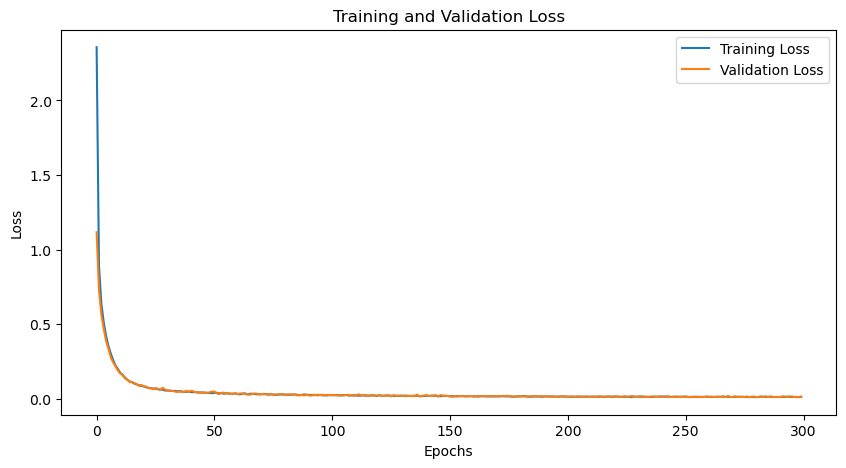

In [14]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

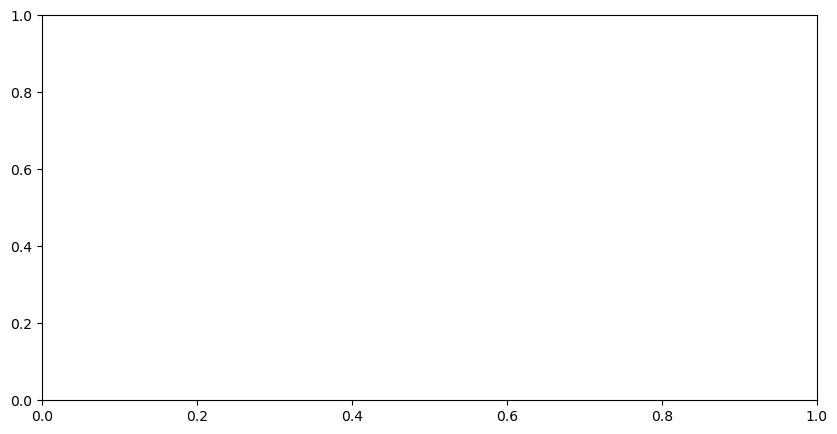

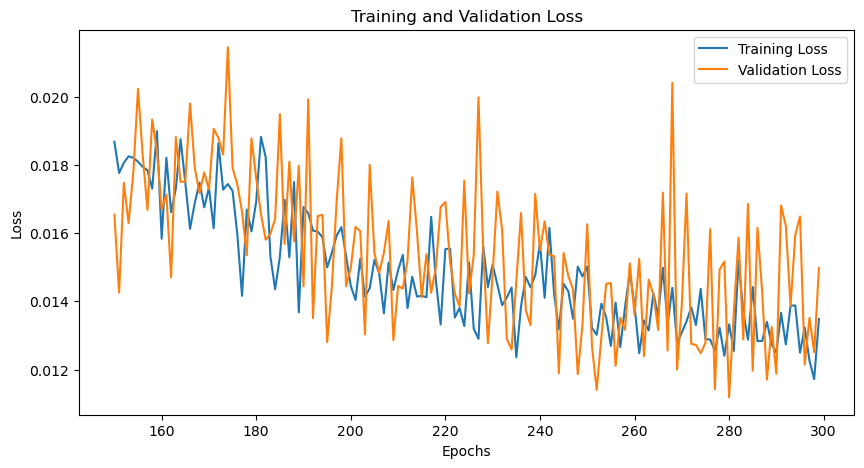

In [15]:
#plot from the middle epoch, to zoom in the plot at the end of training phase
start_ep = min(300, int(n_epochs/2))

try:
    epochs_display = range(start_ep, epoch)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_display,train_losses[start_ep:], label='Training Loss')
    plt.plot(epochs_display,val_losses[start_ep:], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
except:
    epochs_display = range(start_ep, n_epochs)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_display,train_losses[start_ep:], label='Training Loss')
    plt.plot(epochs_display,val_losses[start_ep:], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

plt.legend()
plt.show()


## Sampling with Numerical SDE Solvers
Recall that for any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt + g(t) d\mathbf{w},
\end{align*}
the reverse-time SDE is given by
\begin{align*}
d \mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})] dt + g(t) d \bar{\mathbf{w}}.
\end{align*}
Since we have chosen the forward SDE to be
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
The reverse-time SDE is given by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}.
\end{align*}
To sample from our time-dependent score-based model $s_\theta(\mathbf{x}, t)$, we first draw a sample from the prior distribution $p_1 \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2}(\sigma^{2} - 1) \mathbf{I}\bigg)$, and then solve the reverse-time SDE with numerical methods.

In particular, using our time-dependent score-based model, the reverse-time SDE can be approximated by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} s_\theta(\mathbf{x}, t) dt + \sigma^t d \bar{\mathbf{w}}
\end{align*}

Next, one can use numerical methods to solve for the reverse-time SDE, such as the [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) approach. It is based on a simple discretization to the SDE, replacing $dt$ with $\Delta t$ and $d \mathbf{w}$ with $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, g^2(t) \Delta t \mathbf{I})$. When applied to our reverse-time SDE, we can obtain the following iteration rule
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + \sigma^{2t} s_\theta(\mathbf{x}_t, t)\Delta t + \sigma^t\sqrt{\Delta t} \mathbf{z}_t,
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

### Note that you can find other sampler methods in the original code of Song (ODE sampler, predictor-corrector and Euler-Maruyama sampler). For my dataset, I try all three samplers (ODE, predictor-corrector and Euler-Maruyama sampler) and I choose Euler-Maruyama sampler since it seems to be the best one on my case study.

### Define the Euler-Maruyama sampler as below, here the sampler is extended one dimension to adapt the 3D setting


In [16]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)
from tqdm.notebook import tqdm
## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           time_window=None,
                           y=None,#change 34b: add y here
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  
  #change 50: add more dimension below
  init_x = torch.randn(batch_size, 1, time_window, size_0, size_1, device=device) \
    * marginal_prob_std(t)[:, None,  None,None,None] #change 49: time_window, size_0, size_1#change 50: add more dimension
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x

  
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # print("score_model(x, batch_time_step,y=y) shape: ",score_model(x, batch_time_step,y=y).shape)
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None,None] * score_model(x, batch_time_step,y=y) * step_size #change 34b: add y here#change 50: add more dimension
      x = mean_x + torch.sqrt(step_size) * g[:,None,  None,  None,None] * torch.randn_like(x)  #change 50: add more dimension    
  # Do not include any noise in the last sampling step.
  return mean_x

### Evaluation Dataset Configuration

For evaluation purposes, I have created an additional XArrayDataset as detailed below. This dataset is used to evaluate performance across the entire validation set without restrictions on the percentage of NaN areas. This approach differs from the initial DataLoader setup (at the beginning of this Jupyter notebook), where inputs with insufficient data were excluded to avoid NaN values when computing the loss.

In [17]:
#Evaluate on the whole 1 year dataset, but only inside the considered subset area

class XArrayDatasetWithMask_wholedataset(Dataset):
    def __init__(self, GT, GT_mask, crop_size, output_size, time_window=None, transform=None):
        self.GT_data = GT['SPM'].values  # Assuming 'SPM' is the variable in the dataset
        self.mask_data = GT_mask['SPM'].values  
        self.crop_size = crop_size
        self.output_size = output_size
        self.transform = transform
        self.time_window = time_window 
        self.random_crop = transforms.RandomCrop(crop_size)  # Random crop transformation

    def __len__(self):
        return self.GT_data.shape[0] - self.time_window + 1  
    
    def __getitem__(self, idx): 
        gt_sample = self.GT_data[idx:idx+self.time_window]  # Select a time window
        mask_sample = self.mask_data[idx:idx+self.time_window]
        
        gt_sample = torch.tensor(gt_sample, dtype=torch.float32).unsqueeze(1)#the size will be (time_window, 1, size_0, size_1 here)
        mask_sample = torch.tensor(mask_sample, dtype=torch.float32).unsqueeze(1)
 
        i, j, h, w = 0,60,size_0,size_1
        # print("gt_sample.shape before crop: ", gt_sample.shape)
        gt_sample=transforms.functional.crop(gt_sample, i, j, h, w).squeeze(1).unsqueeze(0) #so that the dimension will be (time_window,1, size_0,size_1)
        mask_sample=transforms.functional.crop(mask_sample, i, j, h, w).squeeze(1).unsqueeze(0)
  
        return gt_sample, mask_sample
    

dataset = XArrayDatasetWithMask_wholedataset(GT_val, GT_with_artificialgappy_val, crop_size=crop_size, output_size=output_size, time_window=time_window)#use val dataset here since we will use it below for evaluation purpose
print("GT_val", GT_val)
    


GT_val <xarray.Dataset> Size: 88MB
Dimensions:  (time: 366, lat: 200, lon: 300)
Coordinates:
  * lat      (lat) float32 800B 52.55 52.56 52.57 52.58 ... 54.6 54.61 54.62
  * lon      (lon) float32 1kB 4.234 4.245 4.255 4.266 ... 7.328 7.339 7.349
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    SPM      (time, lat, lon) float32 88MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:       CF-1.11
    title:             cmems_obs-oc_atl_bgc-transp_my_l3-multi-1km_P1D
    institution:       ACRI
    source:            surface observation
    history:           Created using software developed at ACRI-ST
    contact:           servicedesk.cmems@acri-st.fr
    references:        http://www.globcolour.info GlobColour has been origina...
    comment:           average
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  OCEANCOLOUR_ATL_BGC_L3_MY_009_113
    subset:datasetId:  cmems

## Sampling Process and Evaluation framework

In both training and sampling, the input is 3D, encompassing a time window along with width and height dimensions. Specifically, our input is of size 16x112x112, where '16' represents 16 consecutive days (days 0 through 15). For evaluation purposes, we focus on extracting and plotting data from the middle of the time window, which corresponds to day 7.

In [18]:
#@title Sampling for the whole dataset (except the first and last images)
os.environ["CUDA_VISIBLE_DEVICES"] = gpu
from torchvision.utils import make_grid

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

#(optional) if you have other weight, you can load it the 2 lines below:
# ckpt = torch.load('/homes/n23nguye/Score-Based-Generative-Modeling-Tutorial/scorebased-diffusion/code/ckpt_ConditionalMask_CMEMSdata_3D_Conv3D_widerUnet_smallerbatchsize8_time16_Ep1000.pth', map_location=device)
# score_model.load_state_dict(ckpt)

sampler = Euler_Maruyama_sampler #You can find different sampler in the original code of Song which contains 3 samplers: 'Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'. I chose Euler_Maruyama_sampler since it seems to be the best for my data.
sample_batch_size = 100 # Set the batch size for sampling

data_loader = DataLoader(dataset, batch_size=sample_batch_size, shuffle=False, num_workers=4)

# Prepare to collect samples, averages/ensembles of all samples, and original data for comparison
all_samples = []
all_samples_avg = []
all_originals = []
all_masks = []

# Define the window to plot (middle window)
plot_window=int(time_window/2)-1 #here, we choose the middle one to plot. For example, our input is of size 16*112*112 where 16 indicate 16 consecutive days (day 0, 1, 2, ...15), we extract the middle day which is day 7


for idx, (original_images, mask_images) in enumerate(data_loader):
    print(f"Processing batch index: {idx}")
    mask_images = mask_images.to(device)  # Ensure masks are on the correct device
    mask_images_NantoZero = torch.nan_to_num(mask_images, nan=0.0) # replace Nan by Zero to avoid NaN in computation

    # Perform multiple sampling experiments below. A larger number of samples will provide a better ensemble, but takes longer time for process
    N_experiments=10

    for n_ep in range(N_experiments):
        print("n_ep", n_ep)
        samples = sampler(score_model,
                        marginal_prob_std_fn,
                        diffusion_coeff_fn,
                        mask_images.shape[0],#note that, the last batch might have different shape compared to sample_batch_size
                        y=mask_images_NantoZero,
                        time_window=time_window,
                        device=device)
        if n_ep==0:
            samples_avg=samples.clone()
        else:
            samples_avg+=samples


    samples_avg=samples_avg/N_experiments

    # Convert tensors to NumPy for analysis and plotting
    samples_avg_np = samples_avg.cpu().numpy()  
    samples_np = samples.cpu().numpy()
    mask_images_np = mask_images.cpu().numpy() 
    original_images_np = original_images.cpu().numpy() 
    
    
    # Store the specified window for each sample and mask
    all_samples.append(samples_np[:,0,plot_window,:,:])
    all_samples_avg.append(samples_avg_np[:,0,plot_window,:,:])
    all_masks.append(mask_images_np[:,0,plot_window,:,:])
    all_originals.append(original_images_np[:,0,plot_window,:,:])


# After processing all batches, convert lists to NumPy arrays and Concatenate lists to form complete arrays
all_samples = np.concatenate(all_samples, axis=0)
all_samples_avg = np.concatenate(all_samples_avg, axis=0)
all_masks = np.concatenate(all_masks, axis=0)
all_originals = np.concatenate(all_originals, axis=0)


# Define metrics for evaluation
def rmse(x, y):
    """ Compute Root Mean Squared Error """
    return np.sqrt(np.mean((x - y) ** 2))

def RE(gt, pred):
    """ Compute Relative Error """
    ep = 0.0001  # Small epsilon to avoid division by zero
    return np.mean(np.abs((10 ** gt + ep) - (10 ** pred + ep)) / np.abs(10 ** gt + ep)) * 100

# Apply metrics to valid (non-NaN) data points
valid_mask = ~np.isnan(all_originals) & np.isnan(all_masks)

gt_flat = all_originals[valid_mask]
samples_flat = all_samples[valid_mask]
samples_avg_flat = all_samples_avg[valid_mask]

# Print output results
print('Evaluation for Diffusion: ')
print(f"RMSE 1 sample: {rmse(gt_flat, samples_flat):.3f}")
print(f"RE 1 sample: {RE(gt_flat, samples_flat):.3f}%")

print(f"RMSE {N_experiments} samples: {rmse(gt_flat, samples_avg_flat):.3f}")
print(f"RE {N_experiments} samples: {RE(gt_flat, samples_avg_flat):.3f}%")

print(" np.unique(original_images_np) : ", np.unique(original_images_np))
print(" np.unique(mask_images_np) : ", np.unique(mask_images_np))
print("np.unique(samples_np): ", np.unique(samples_np))


Processing batch index: 0
n_ep 0


/tmp/ipykernel_2730741/3315192203.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_2730741/3315192203.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


n_ep 1


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 2


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 3


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 4


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 5


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 6


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 7


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 8


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 9


  0%|          | 0/500 [00:00<?, ?it/s]

Processing batch index: 1
n_ep 0


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 1


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 2


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 3


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 4


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 5


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 6


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 7


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 8


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 9


  0%|          | 0/500 [00:00<?, ?it/s]

Processing batch index: 2
n_ep 0


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 1


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 2


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 3


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 4


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 5


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 6


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 7


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 8


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 9


  0%|          | 0/500 [00:00<?, ?it/s]

Processing batch index: 3
n_ep 0


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 1


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 2


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 3


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 4


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 5


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 6


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 7


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 8


  0%|          | 0/500 [00:00<?, ?it/s]

n_ep 9


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluation for Diffusion: 
RMSE 1 sample: 0.224
RE 1 sample: 36.387%
RMSE 10 samples: 0.213
RE 10 samples: 34.527%
 np.unique(original_images_np) :  [-1.30103   -1.3010299 -1.0769699 ...  1.9999256  2.               nan]
 np.unique(mask_images_np) :  [-1.30103   -1.3010299 -0.9265131 ...  1.8877743  1.9222935        nan]
np.unique(samples_np):  [-2.0218296 -1.9852705 -1.8822148 ...  1.8457261  1.919835   2.09419  ]


### Please change the path of land_mask before running this below visualization

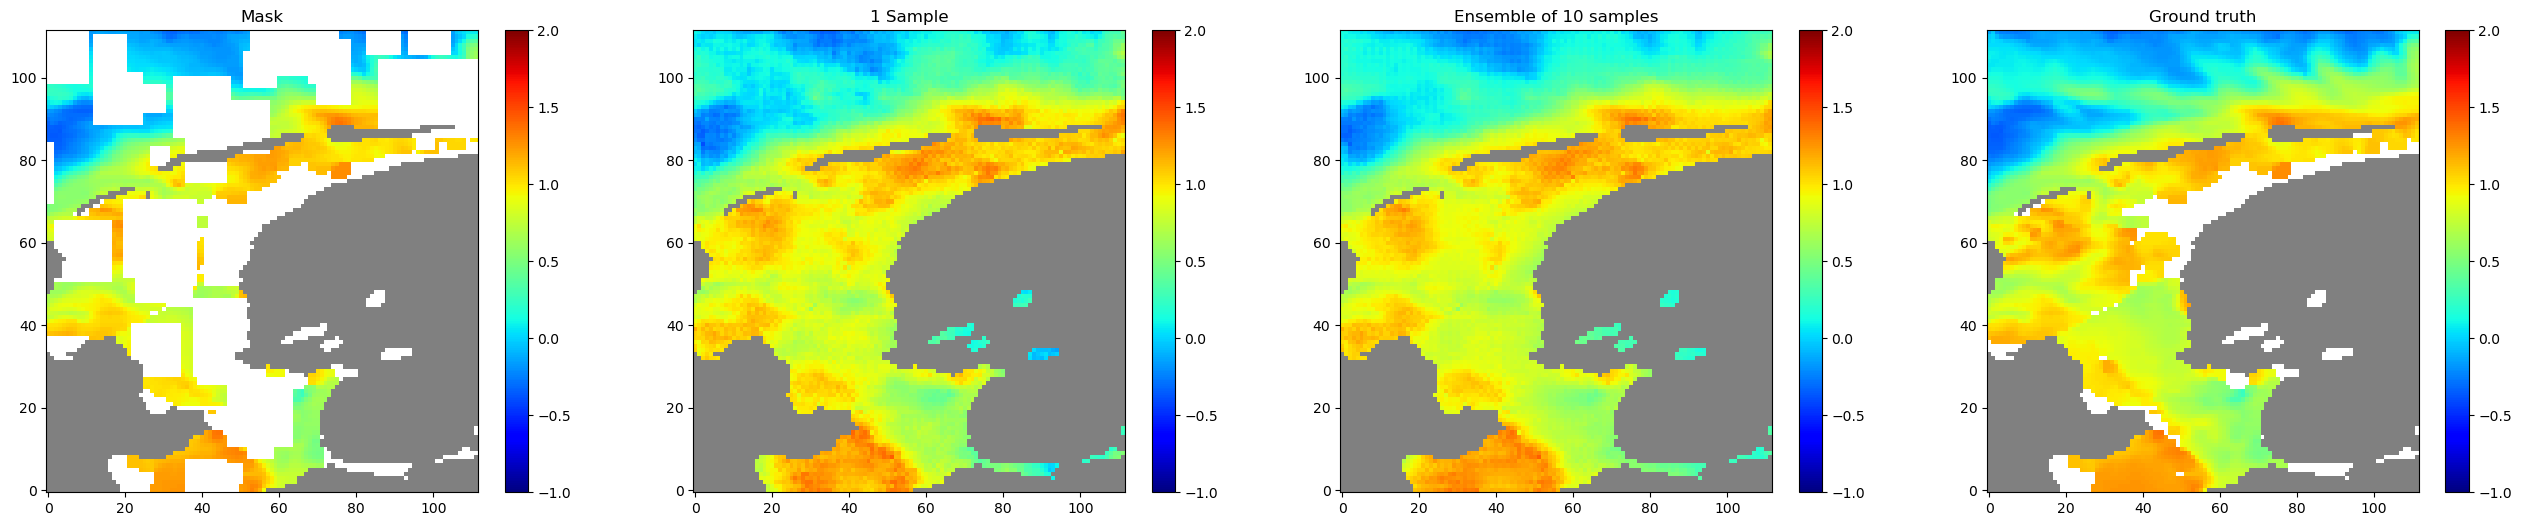

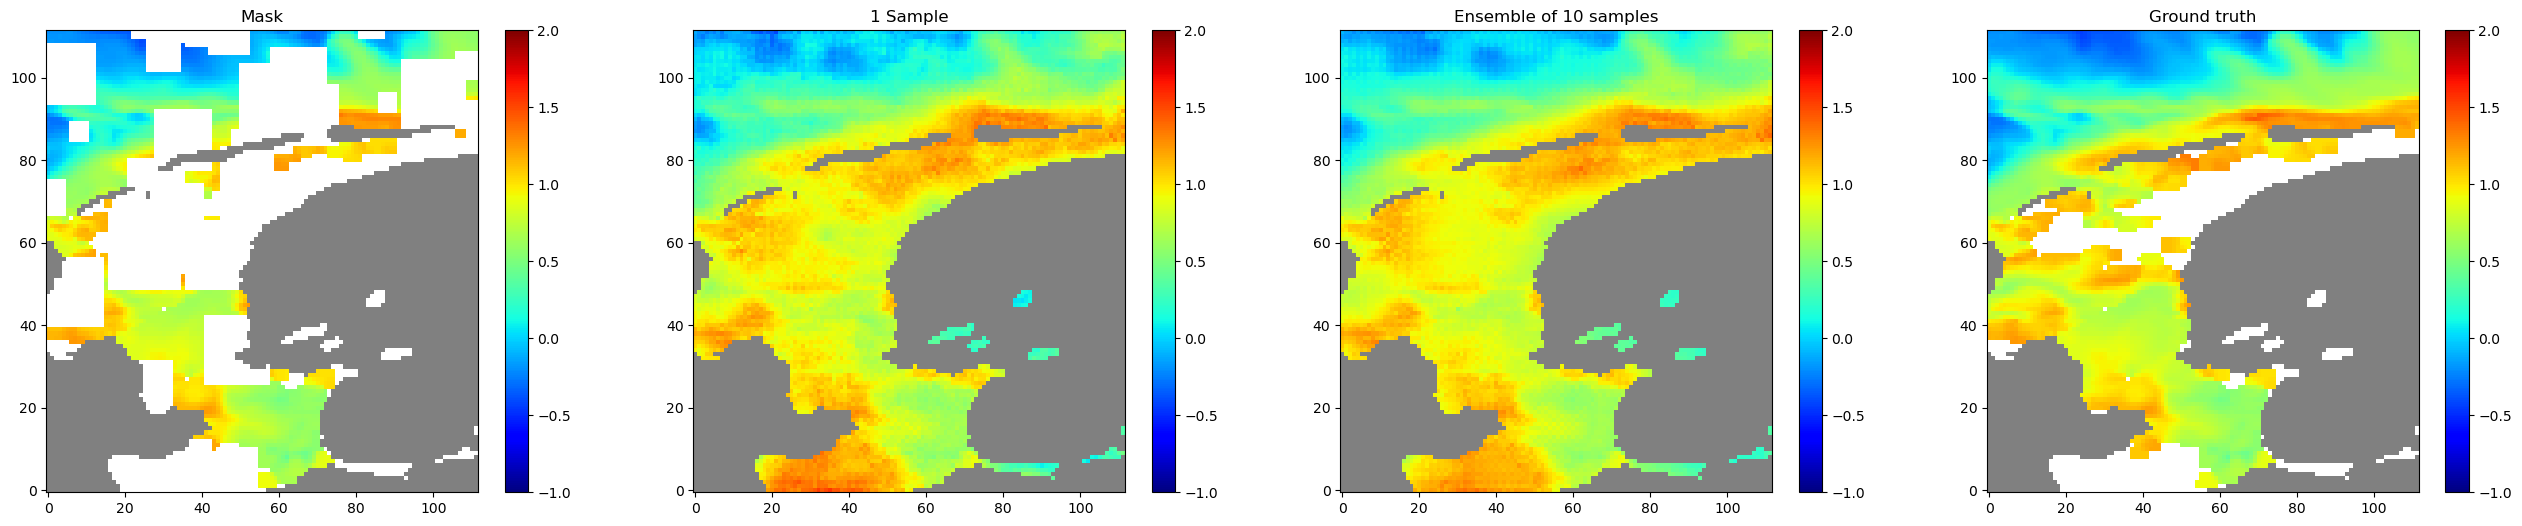

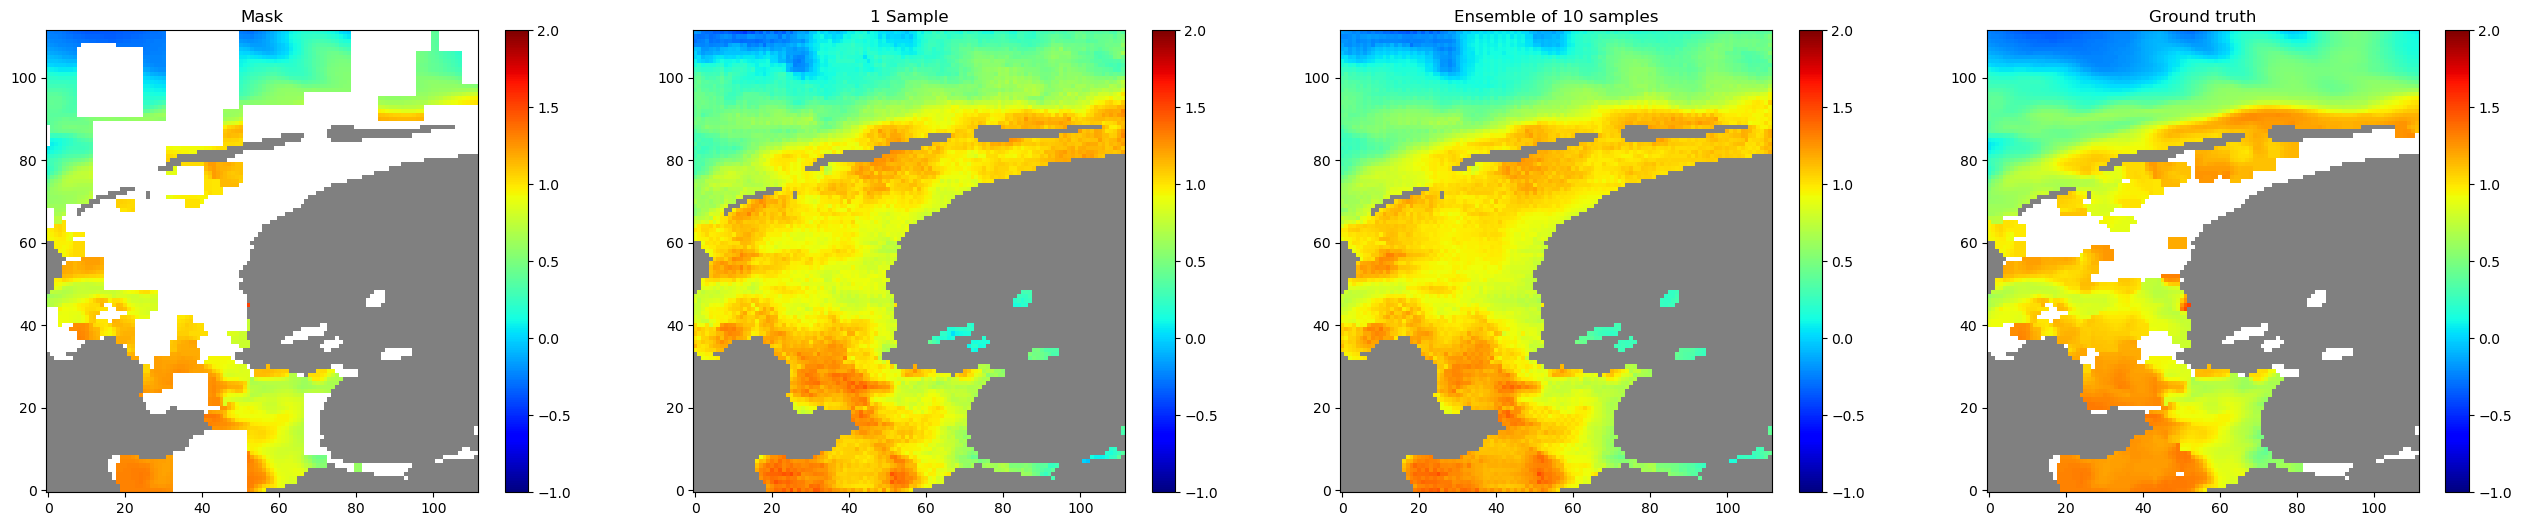

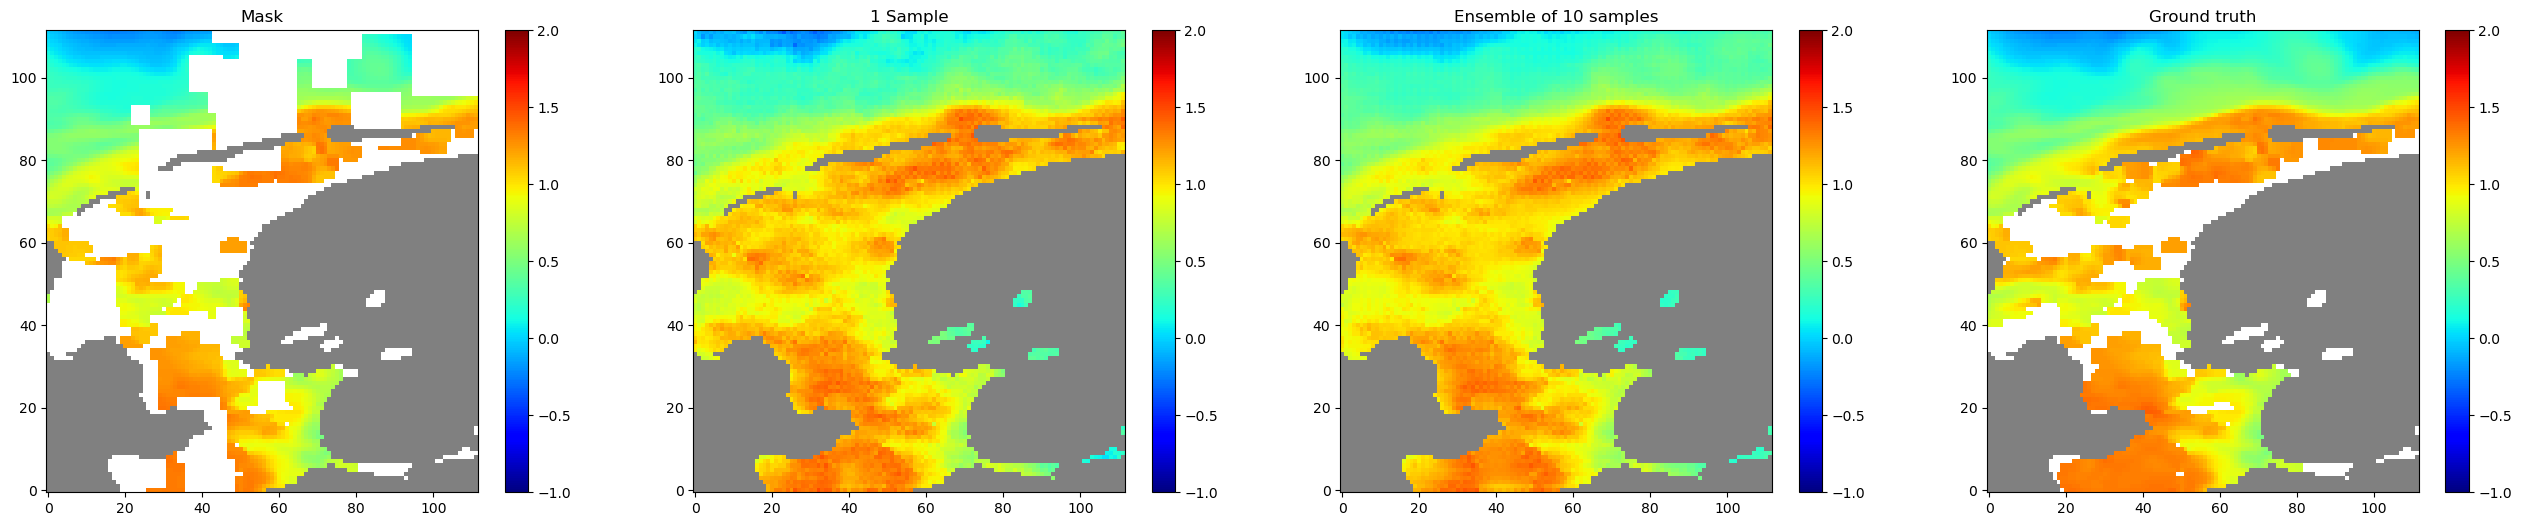

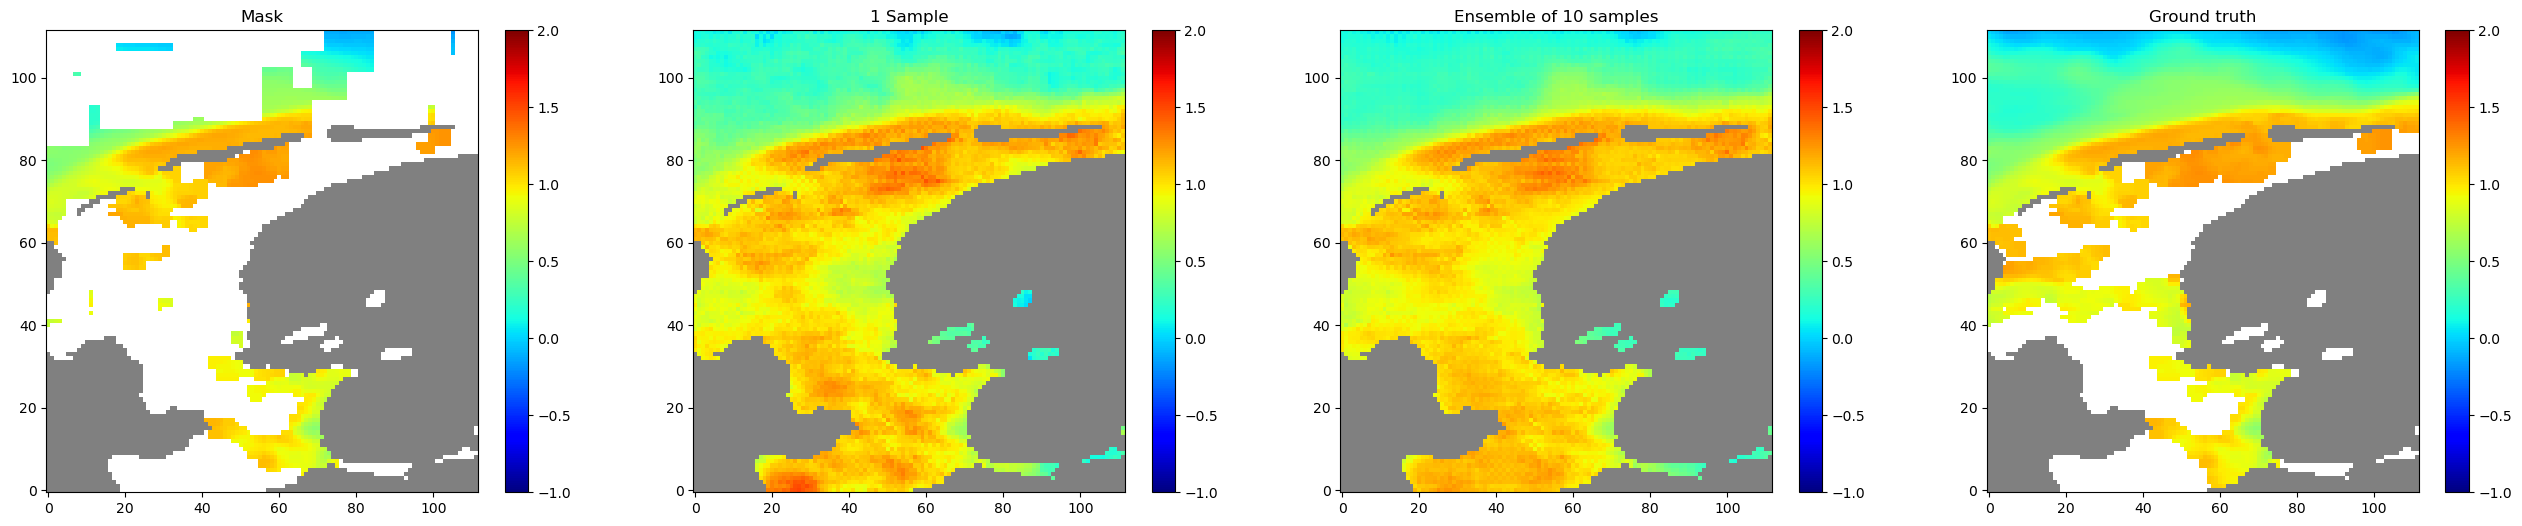

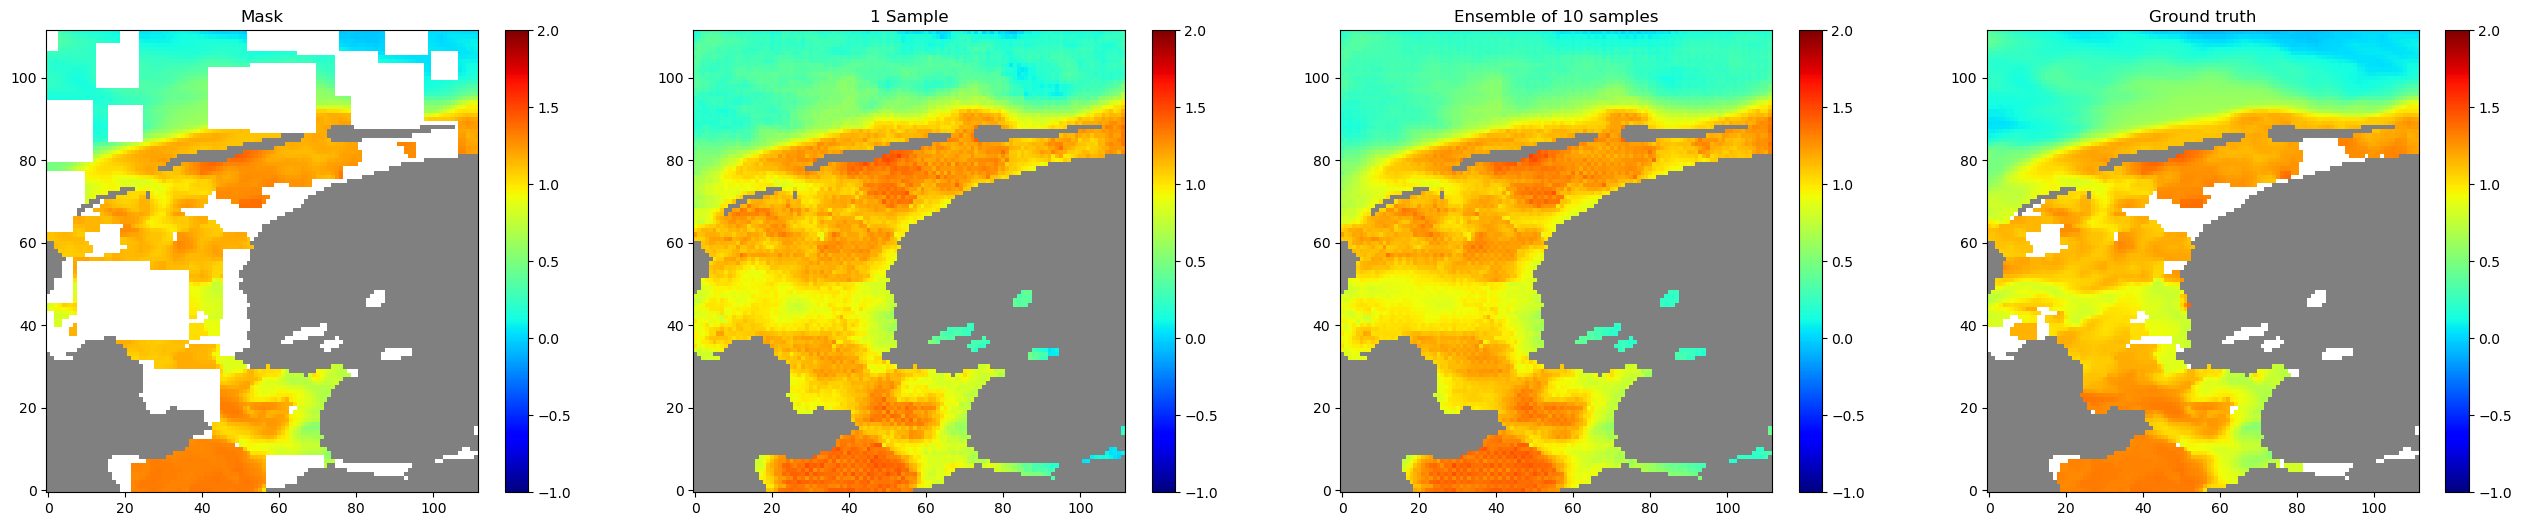

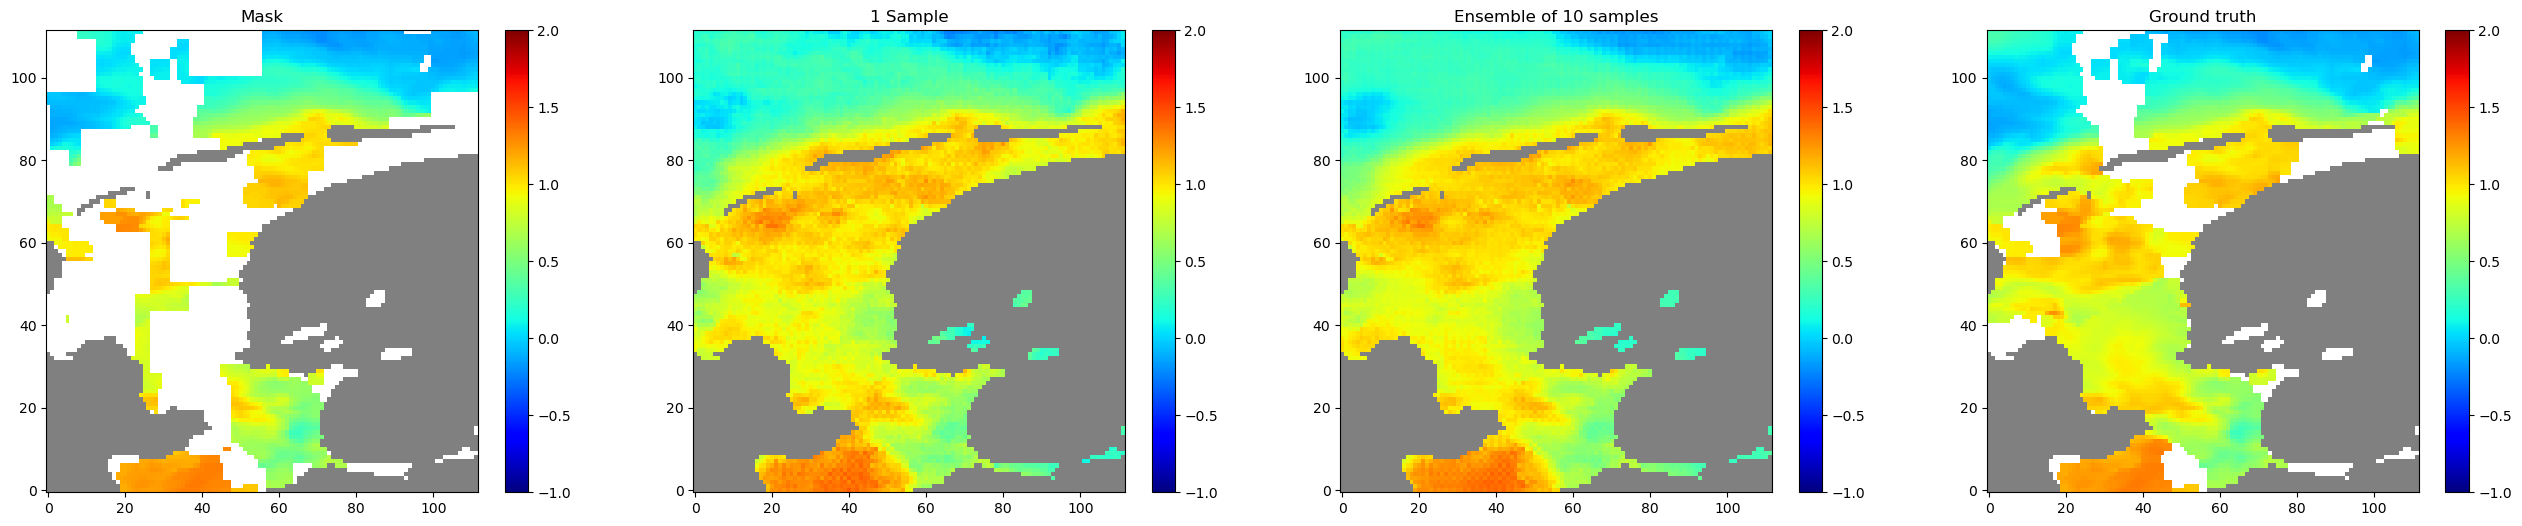

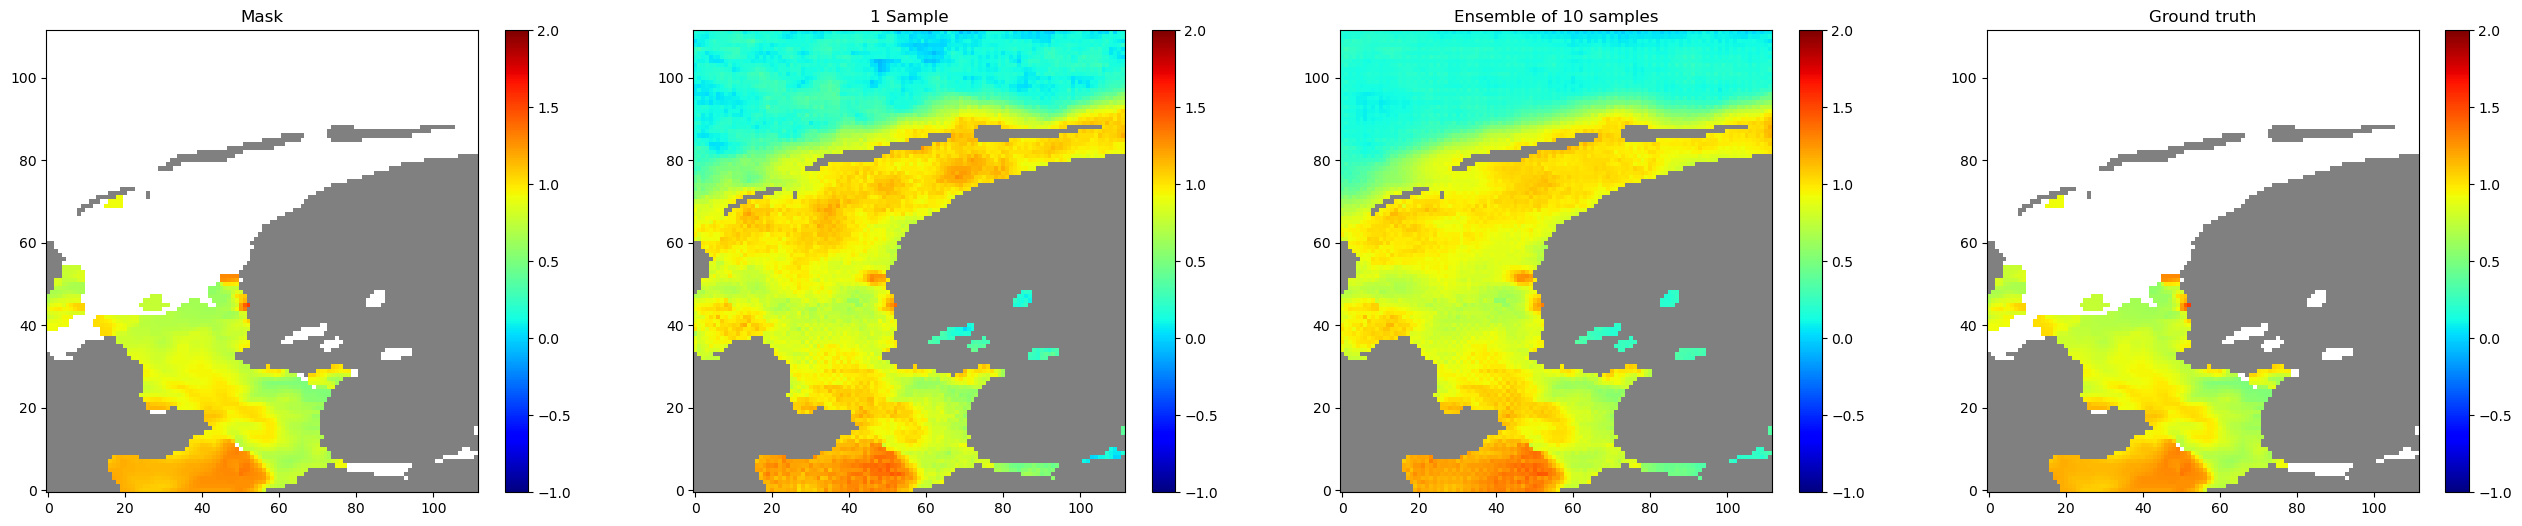

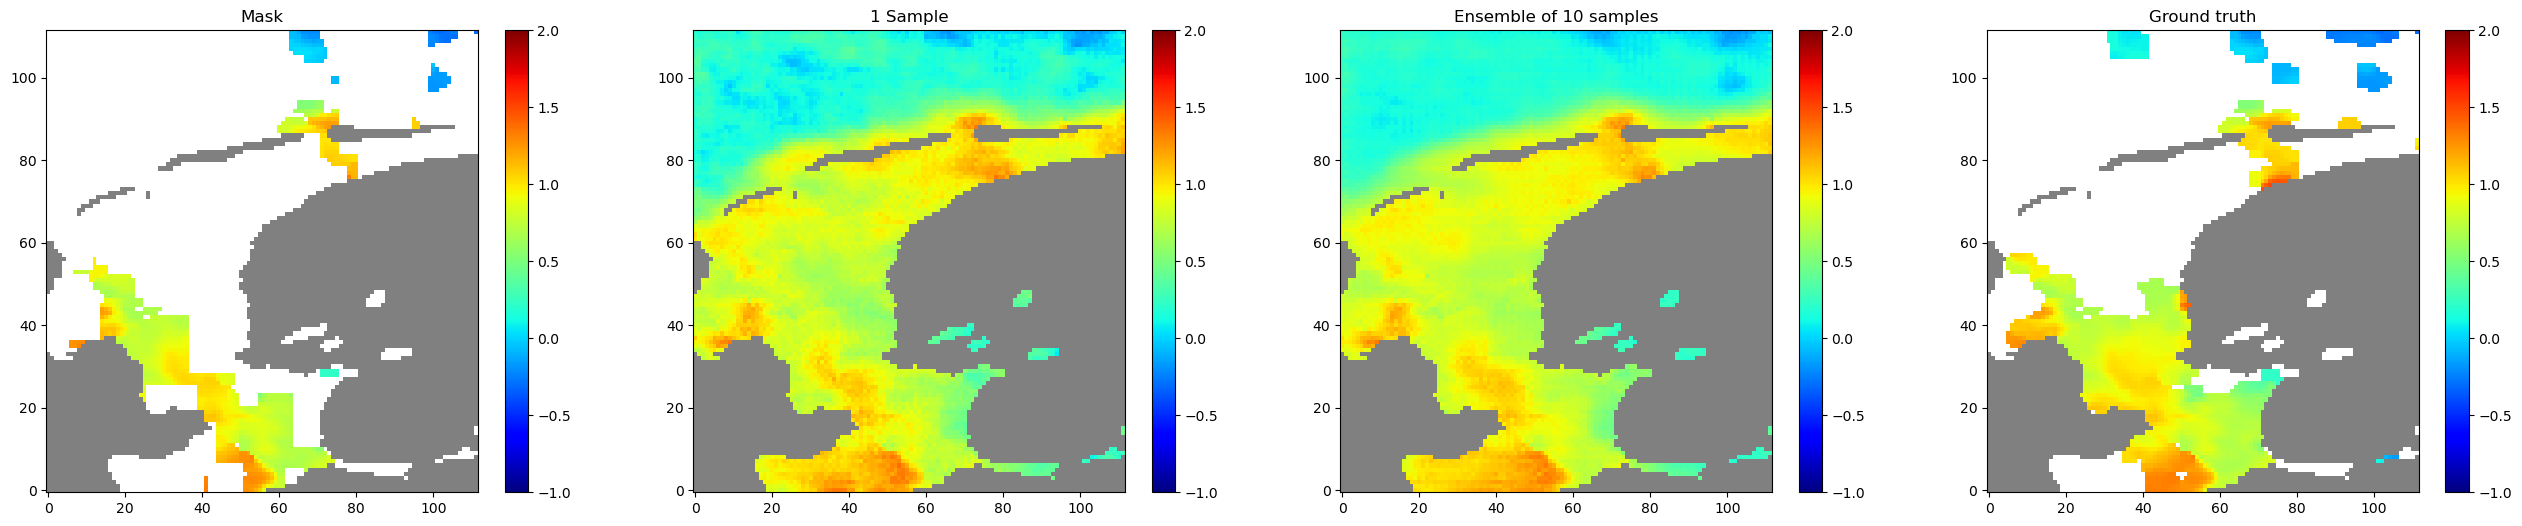

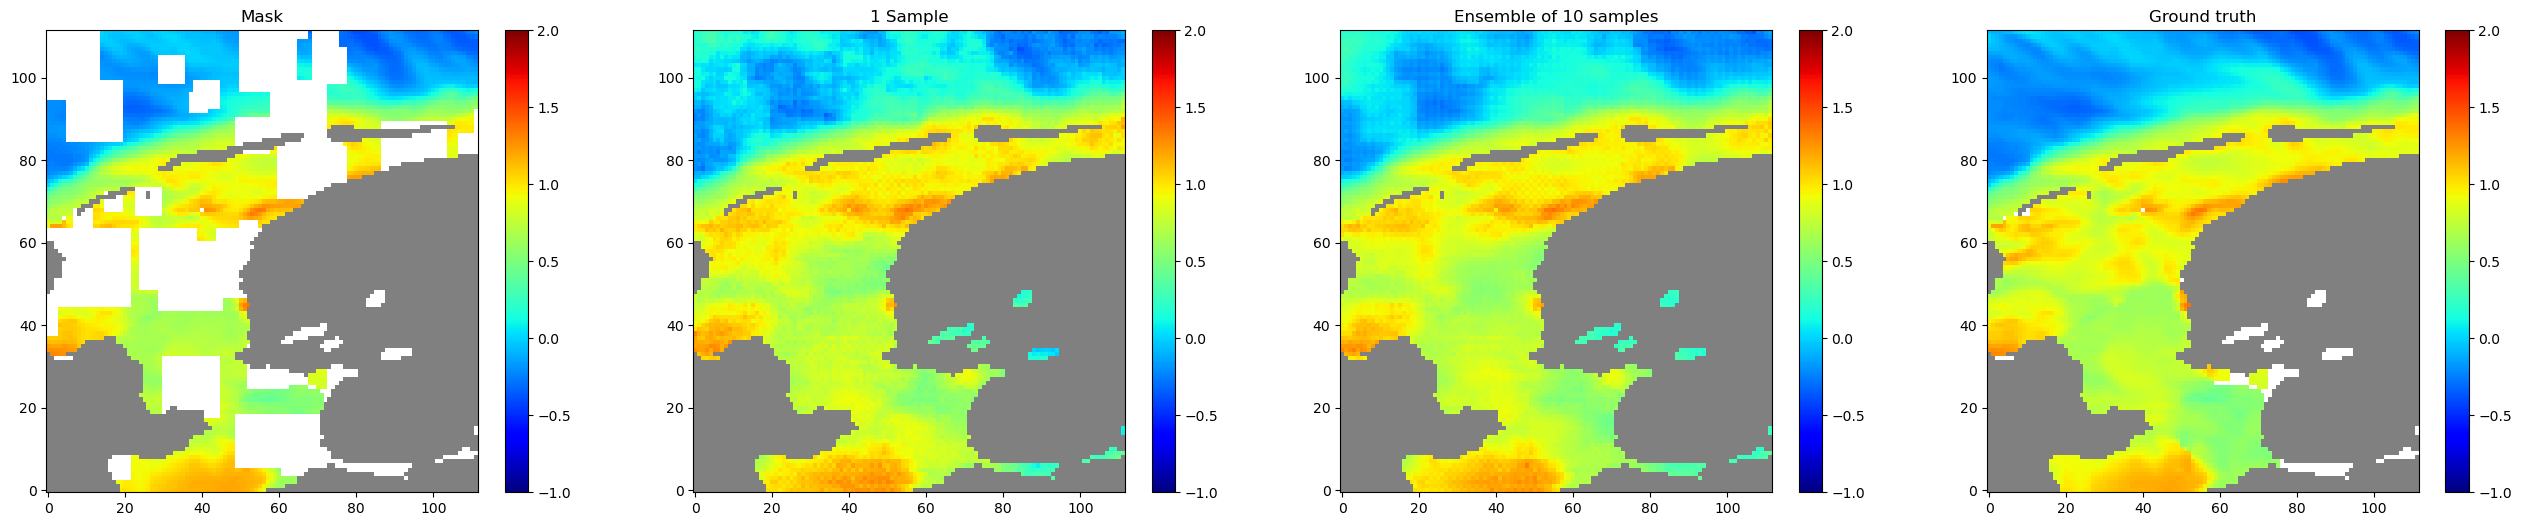

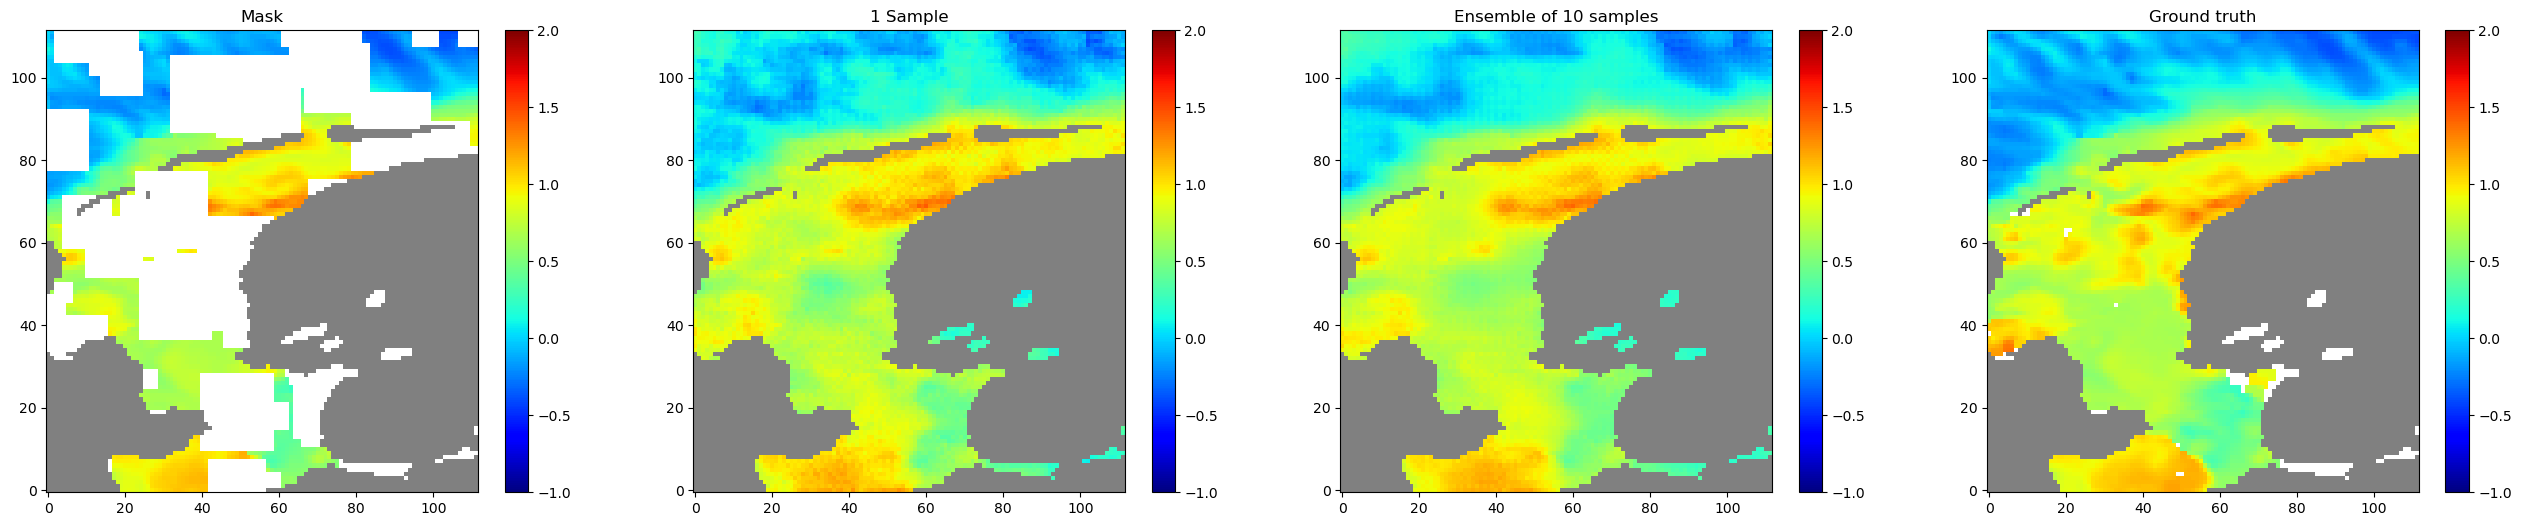

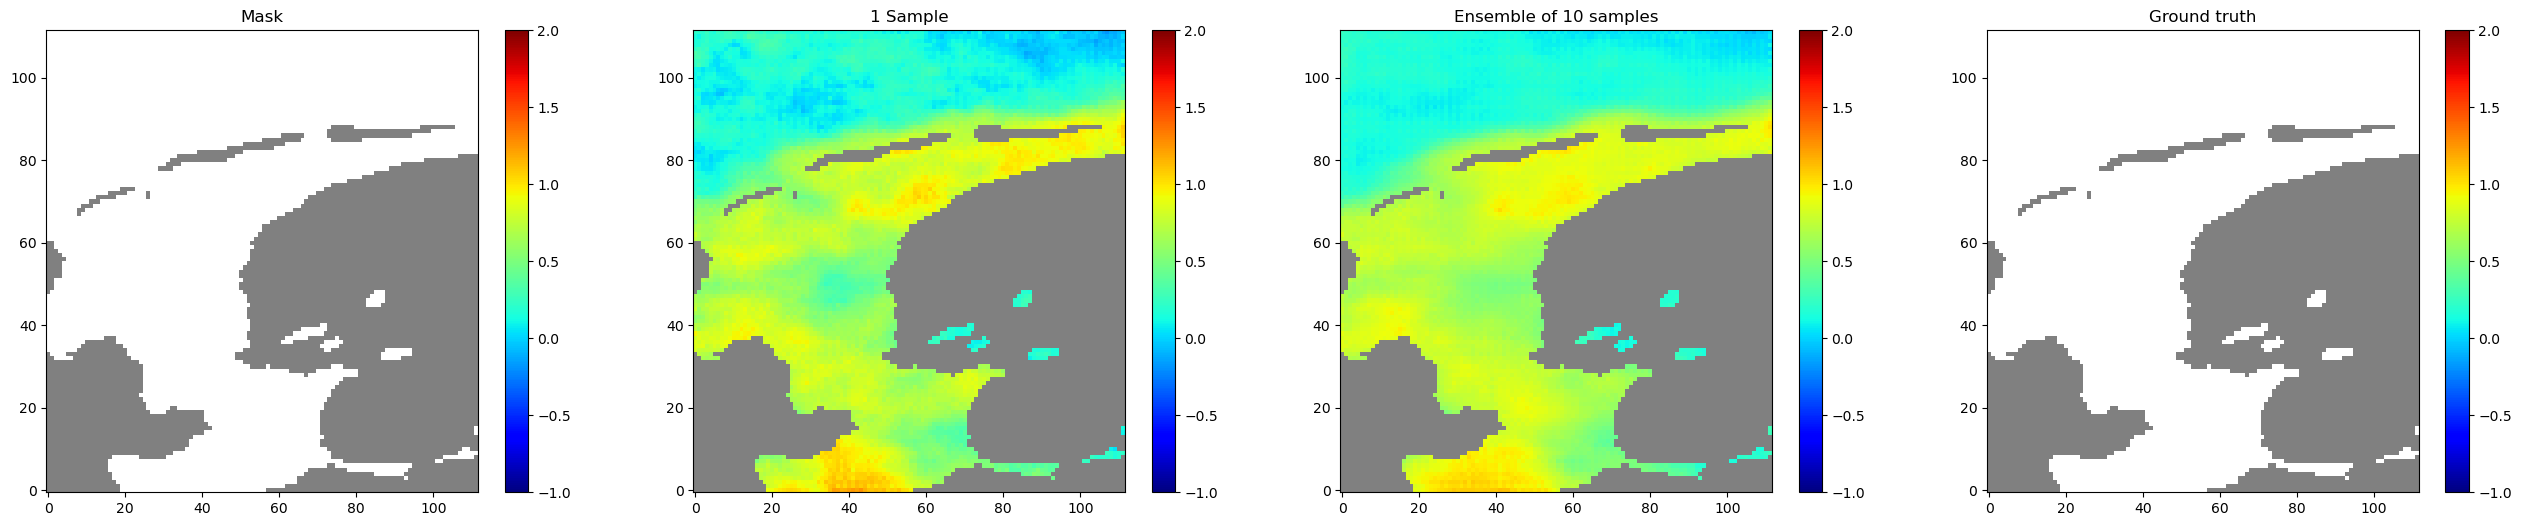

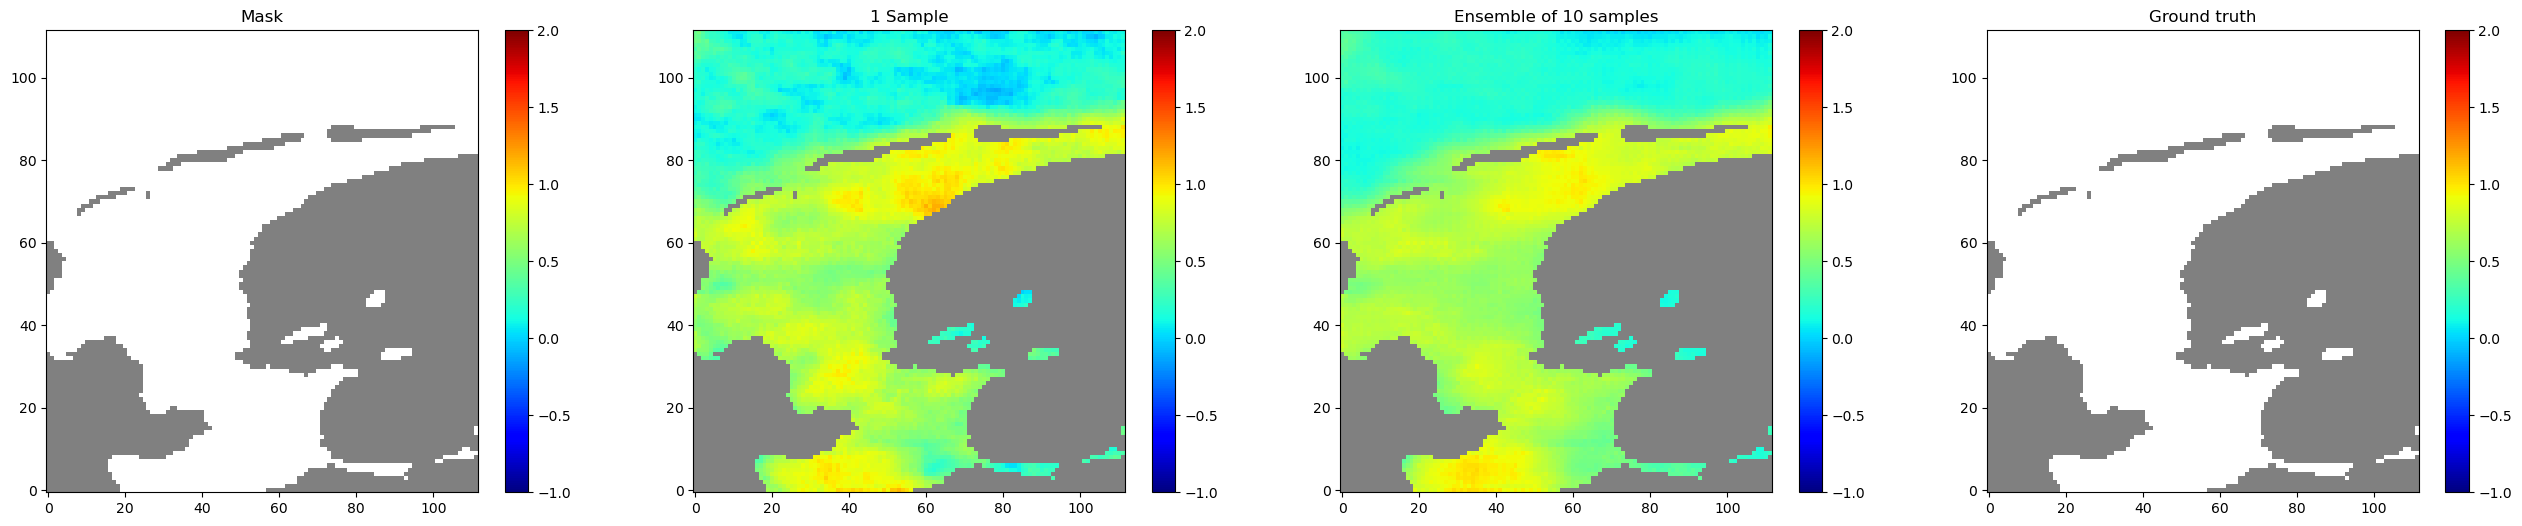

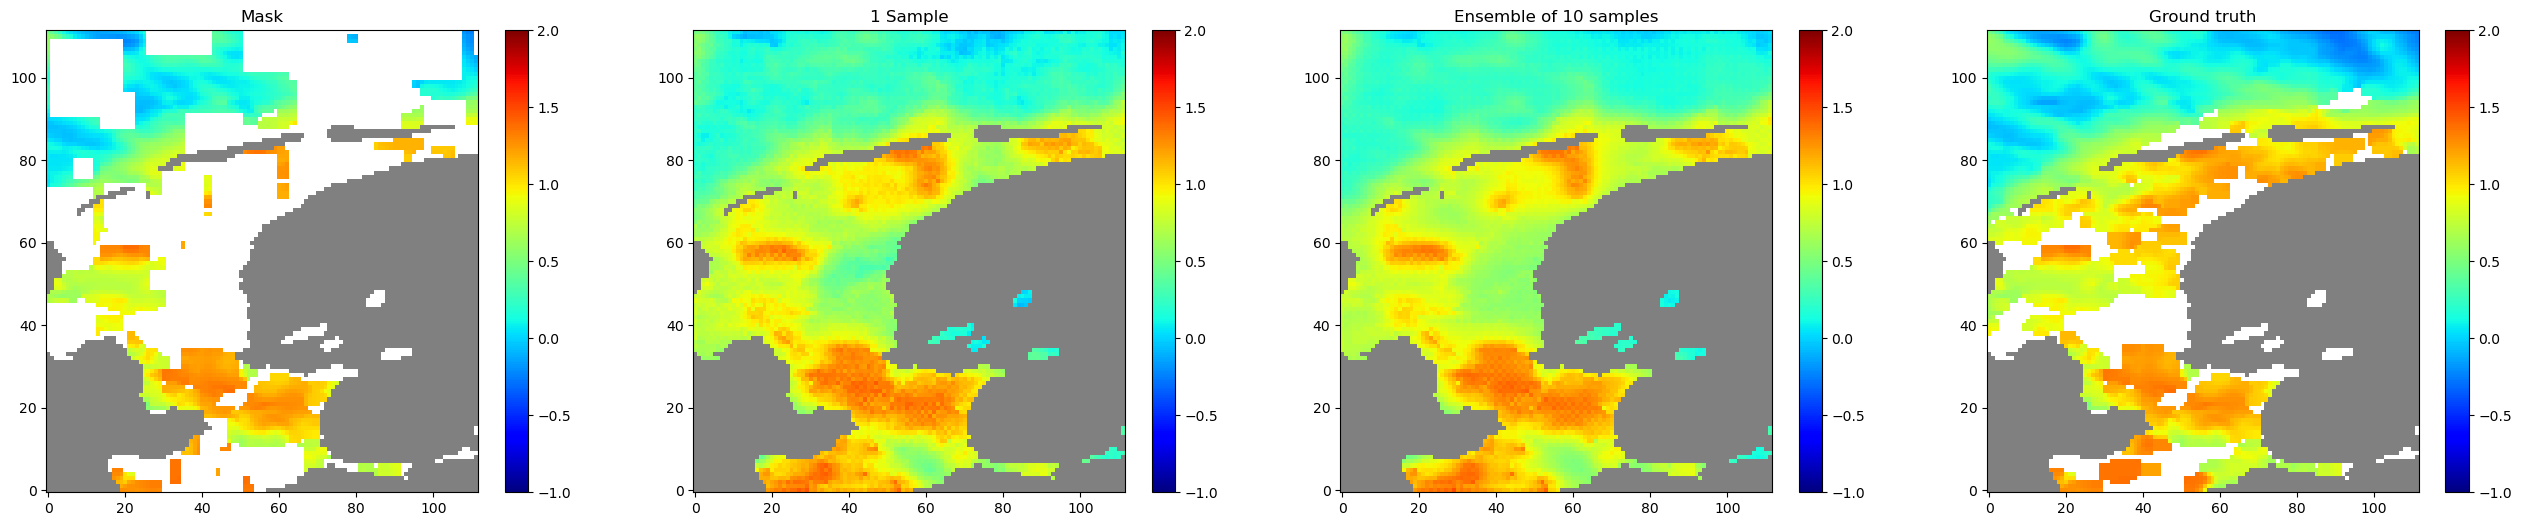

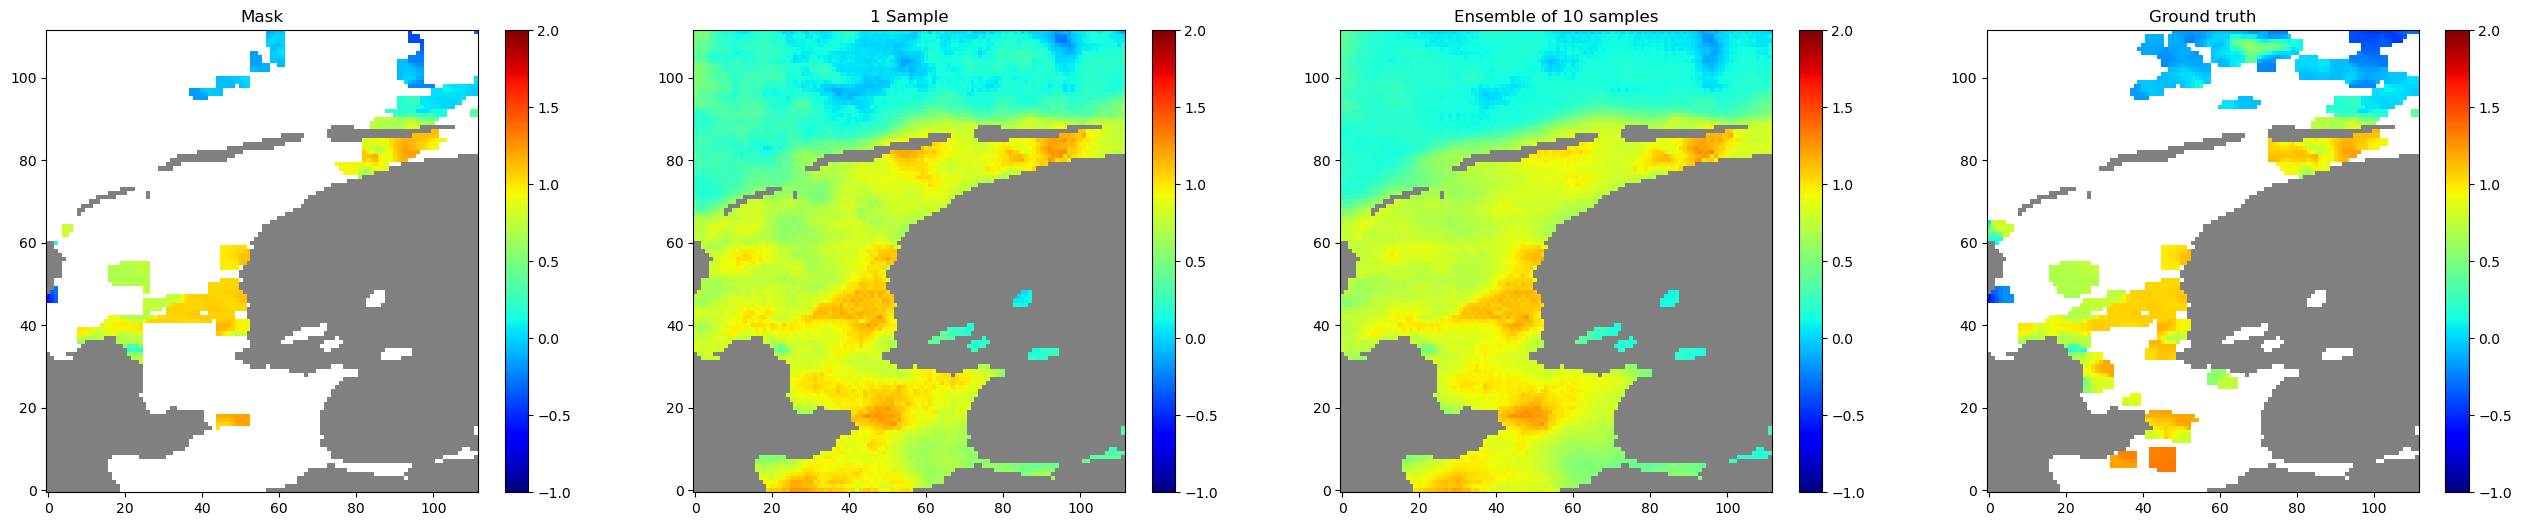

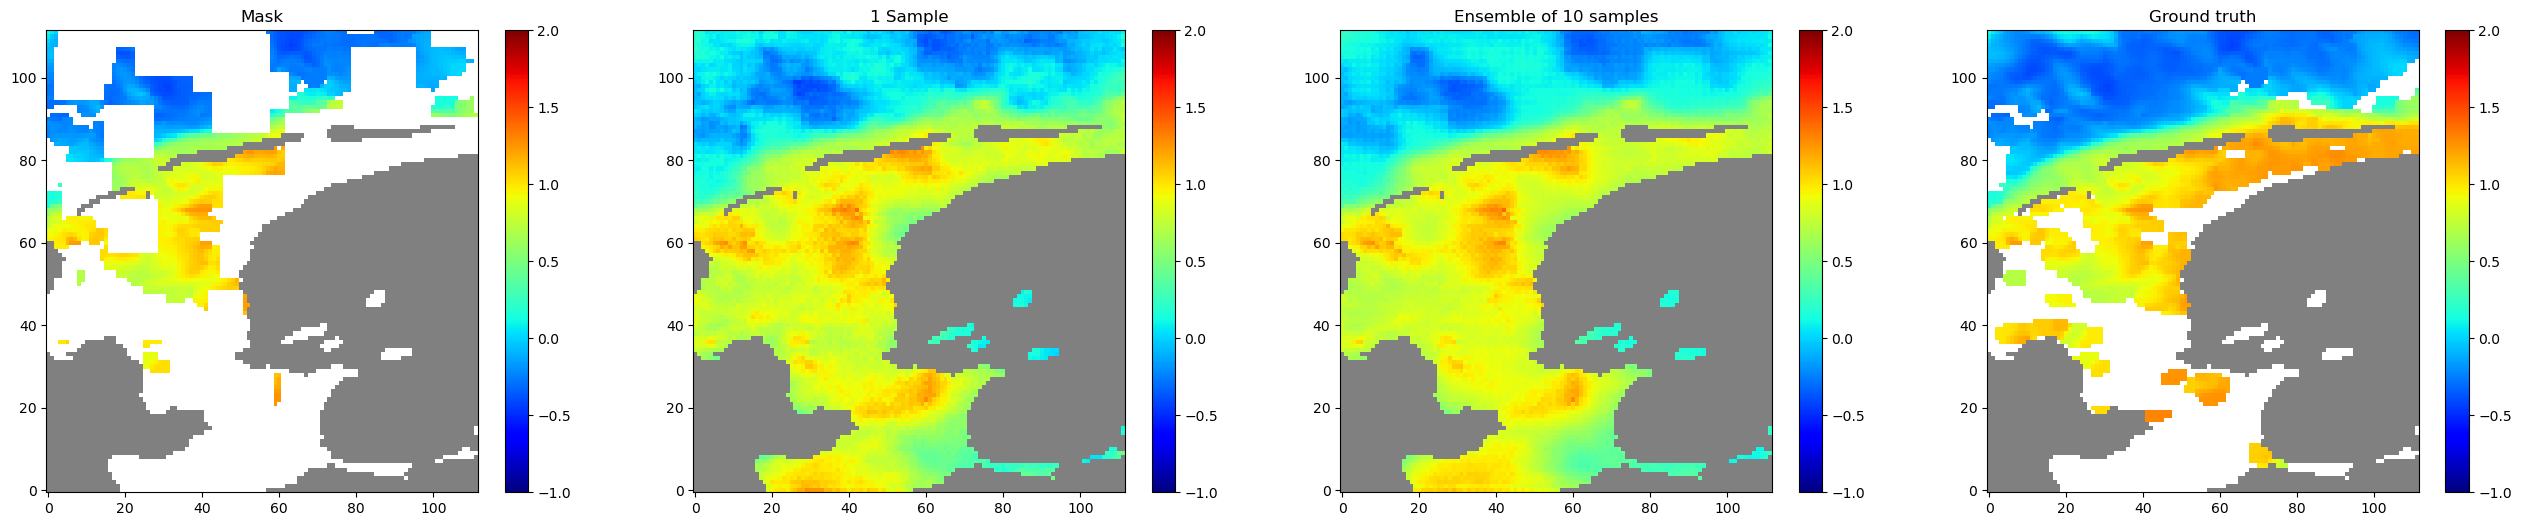

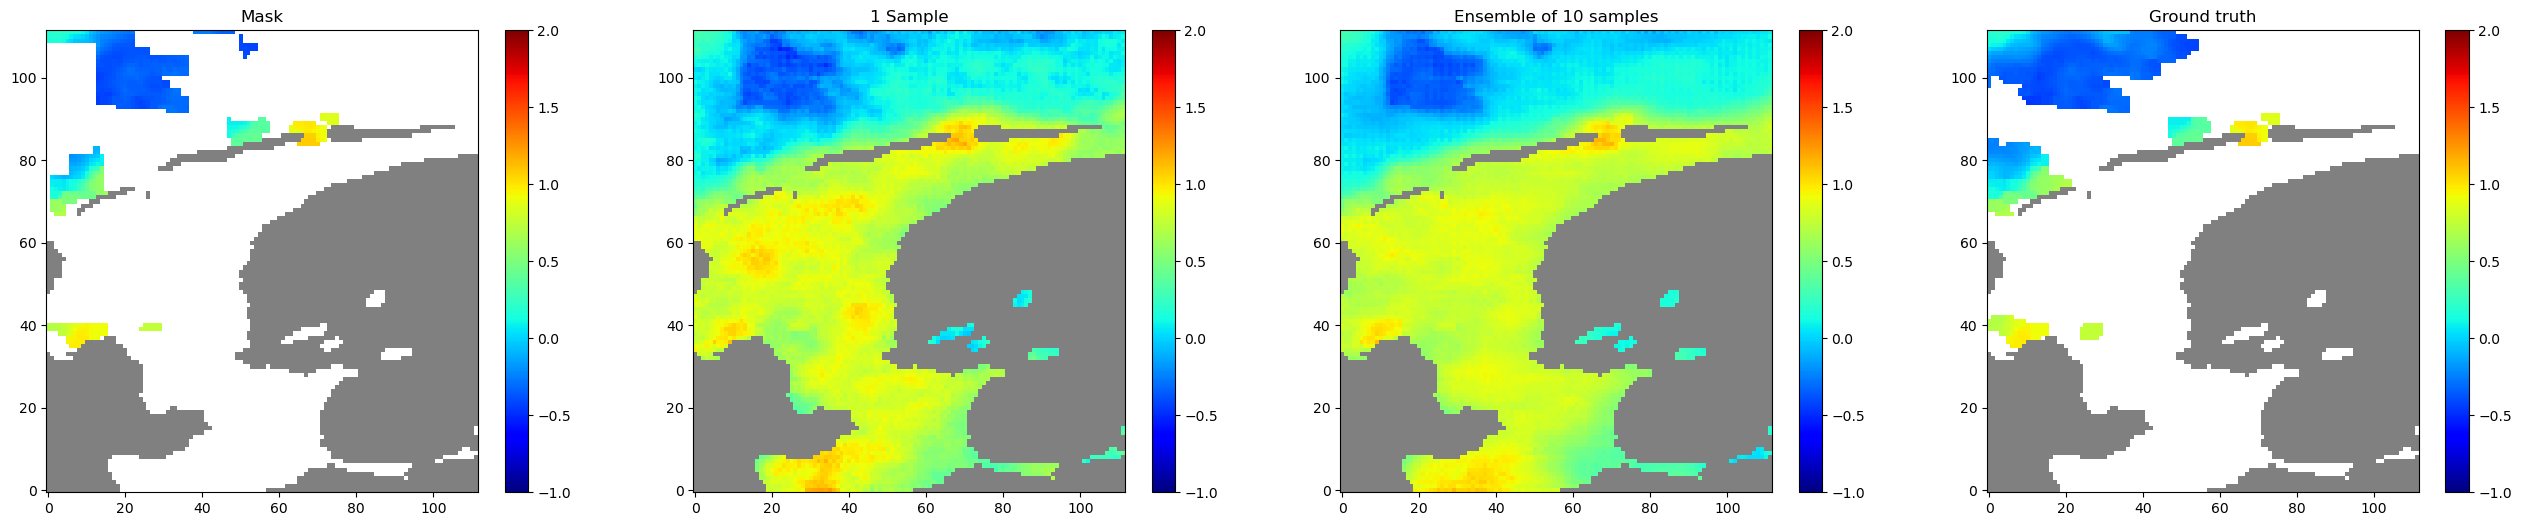

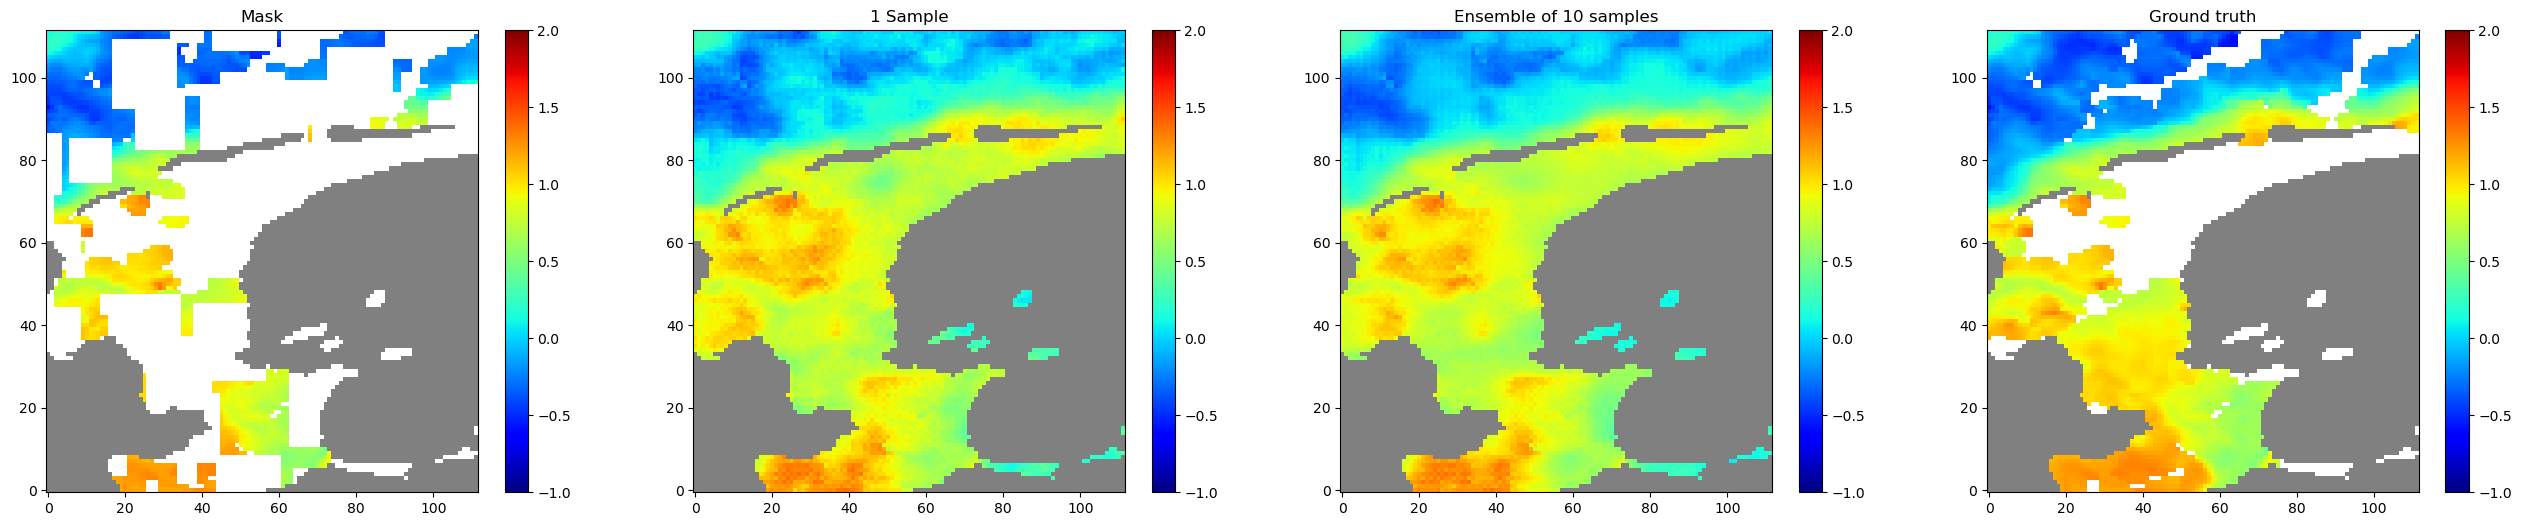

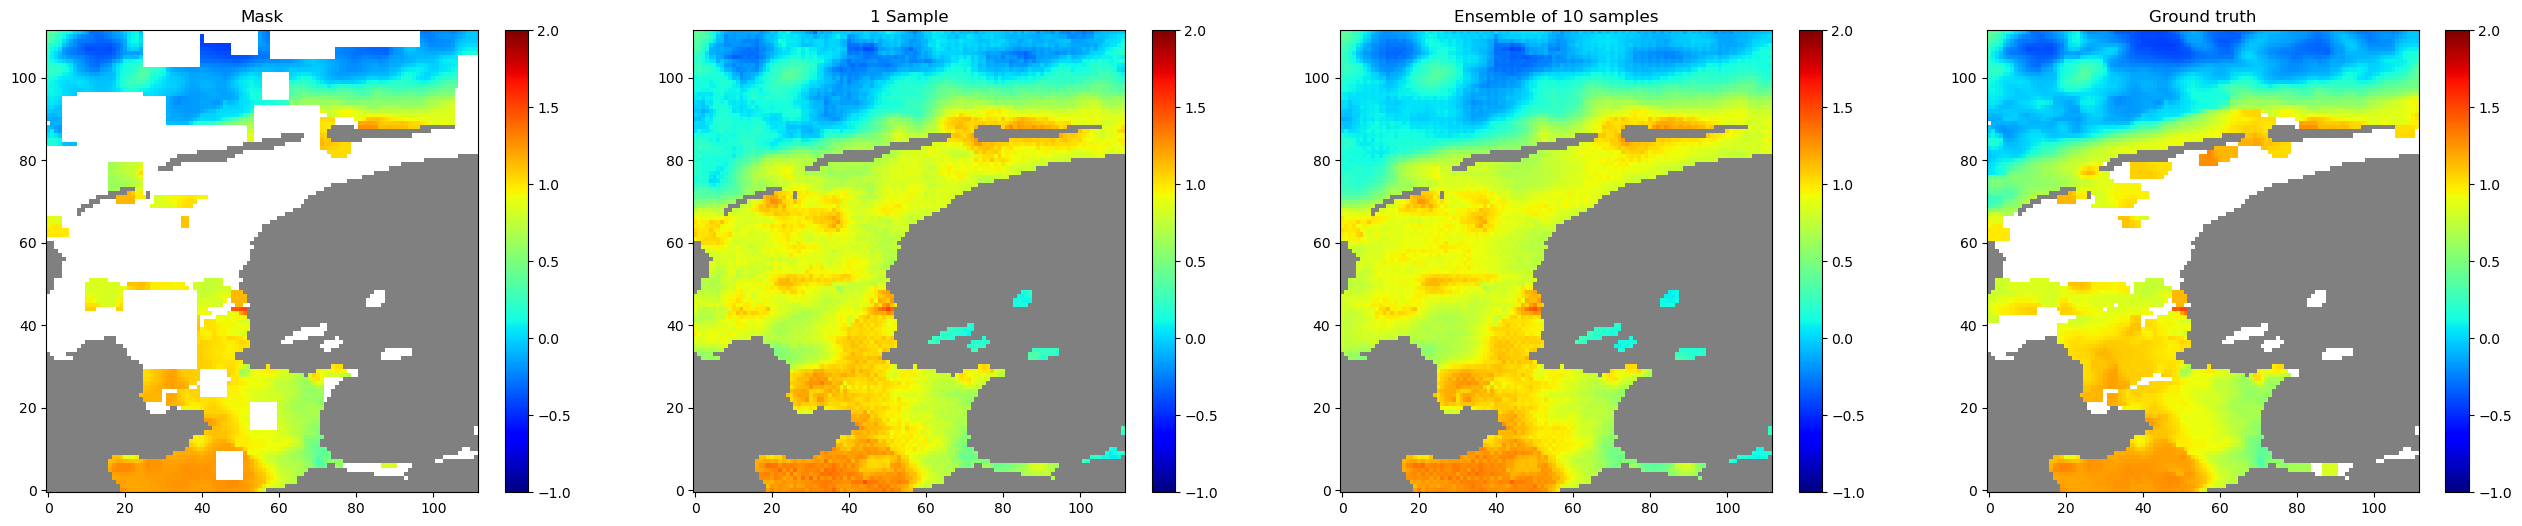

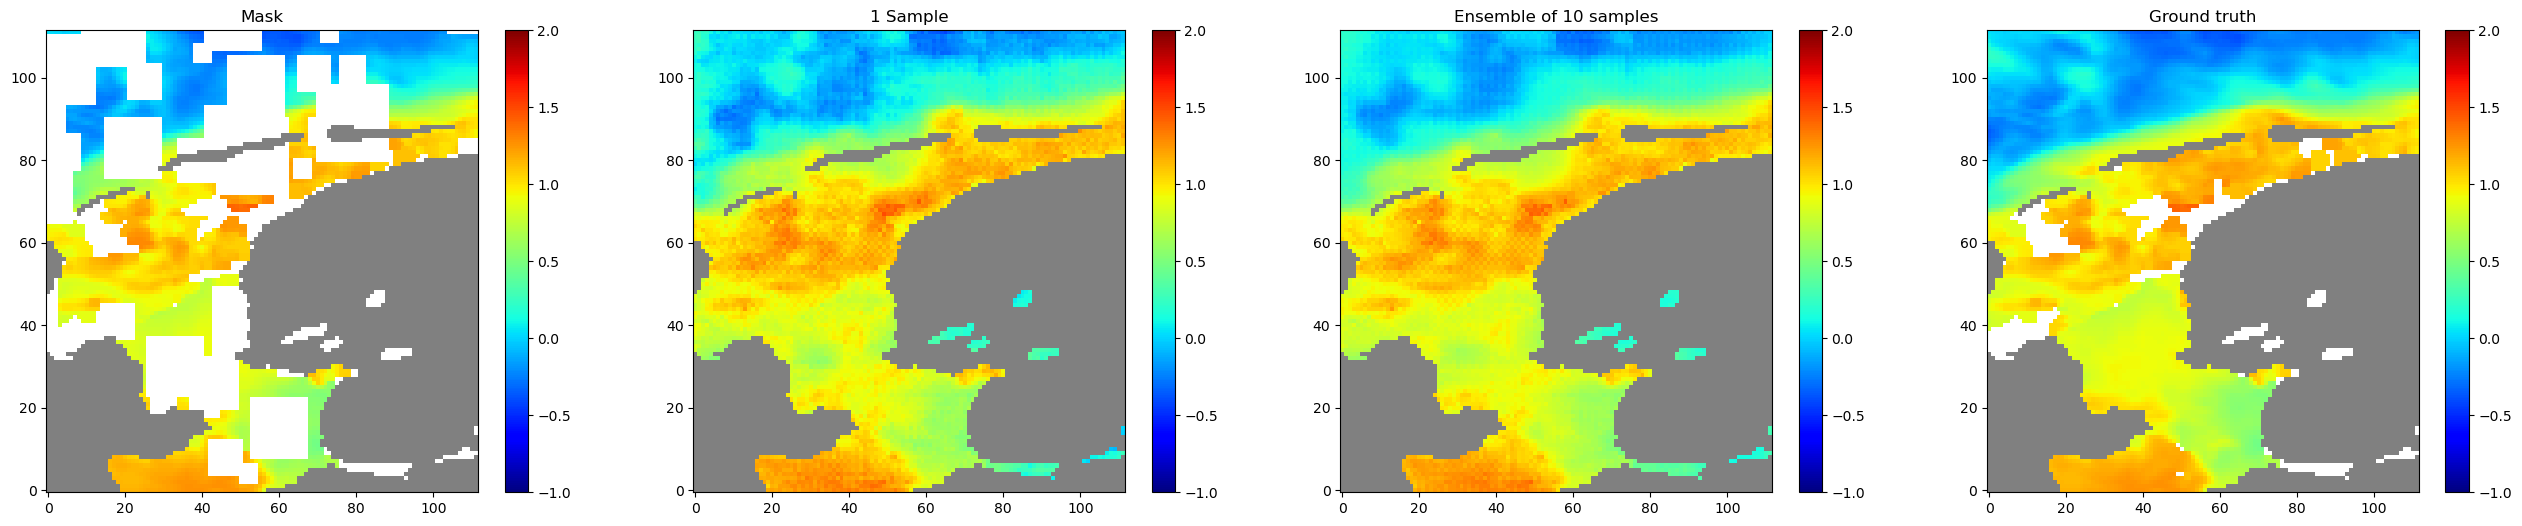

In [19]:
# Load the land mask, please change the path below:
land_mask=xr.open_dataarray('/Odyssey/private/n23nguye/data_nga/Delft3Dmodel_CMEMS_size200T300/CMEMS/land_mask_CMEMS_size200T300.nc')

# Parameters for the cropped area used in evaluation, here we choose an area near the coast with high turbidity
i, j, h, w = 0, 60,size_0,size_1 #the parameters for the cropped area used in evaluation, we want to choose an area near the coastal with high turbidity 
land_mask=land_mask.values[i:i + h, j:j + w]

# Set color scale limits for better contrast visually display in the plot
v_min=-1
v_max=2

#x, y are latitude and longitude
x = np.arange(0, h ) 
y = np.arange(0, w)

# Loop through selected time frames, select the range time you want to display
for t in range(100,120,1):

    fig, axes = plt.subplots(1, 4, figsize=[6*4+2*4, 6])  # Adjust the figsize if needed

    # Plot the first image
    # print("x.shape, y.shape, mask_images_np[t,0, plot_window].shape: ",x.shape, y.shape, mask_images_np[t,0, plot_window].shape)
    mappable0 = axes[0].pcolormesh(x, y, all_masks[t], cmap='jet', vmin=v_min, vmax=v_max)
    axes[0].pcolormesh(x, y, land_mask, cmap='gray', vmin=0, vmax=2)
    axes[0].set_title("Mask")
    fig.colorbar(mappable0, ax=axes[0])

    # Plot the second image (simulated observation)
    mappable1 = axes[1].pcolormesh(x, y, all_samples[t], cmap='jet', vmin=v_min, vmax=v_max)
    axes[1].pcolormesh(x, y, land_mask, cmap='gray', vmin=0, vmax=2)
    axes[1].set_title("1 Sample")
    fig.colorbar(mappable1, ax=axes[1])

   
    # Plot the third image (another simulated observation)
    mappable2 = axes[2].pcolormesh(x, y, all_samples_avg[t], cmap='jet', vmin=v_min, vmax=v_max)
    axes[2].pcolormesh(x, y, land_mask, cmap='gray', vmin=0, vmax=2)
    axes[2].set_title(f'Ensemble of {N_experiments} samples')
    fig.colorbar(mappable2, ax=axes[2])

    # Plot the third image (another simulated observation)
    mappable3 = axes[3].pcolormesh(x, y, all_originals[t], cmap='jet', vmin=v_min, vmax=v_max)
    axes[3].pcolormesh(x, y, land_mask, cmap='gray', vmin=0, vmax=2)
    axes[3].set_title("Ground truth")
    fig.colorbar(mappable3, ax=axes[3])


    # filename = f'plots/ckpt_Nan_ConditionalMask_lsubsetnotfixed_losswholeimage_CMEMSdata_TrainValSeparate_3D_Ep999_{N_experiments}_sample_{t}.png'
    # plt.savefig(filename)  # Save the figure to a file

    plt.show()  # Display the plot

### Notes
By increasing number of training epochs (n_epochs to 1000), increasing number of steps in sampling method (num_steps to 1000 or 2000 for example), and increasing the number of samples (N_experiments to 10 or more for examples), and increase the channels of UNet to [64, 128, 256, 512], we'll get a bit better interpolation, however it will increase the computing time a lot.